Importamos las librerías que se van a usar.

In [57]:
import numpy as np
import pandas as pd
from google.cloud import translate_v2 as translate
import os
import requests
from bs4 import BeautifulSoup as bs
from nltk import word_tokenize
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import single_meteor_score
from sacrebleu import TER
import Levenshtein
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy import stats


Creamos una función para hacer obtener el texto de la base de datos de eur-lex con el formato deseado. A la hora de ejecutar el código, se ha tenido que añadir una excepción, ya que en la página existían celdas vacías cuyos contenido era "EMPTY", por tanto, en algún idioma no se podía alinear el texto en Dataframe porque se generaban filas desiguales.

In [14]:
def df_multingue1(urls:list):
    """
    Función para hacer web scraping en eur-lex.

    Args:
        urls: lista de urls de las que se quiere obtener el texto

    Returns:
        pd.dataframe con el texto alineado en tres columnas por idioma.

    """
    entrega_dict = {"Idioma original(EN)": [],
                    "Traducción ES": [],
                    "Traducción RO": []}

    for url in urls:
        response = requests.get(url)
        html = response.content

        soup = bs(html, "html.parser")

        texts_en = soup.find_all("td", lang="EN")
        texts_es = soup.find_all("td", lang="ES")
        texts_ro = soup.find_all("td", lang="RO")

        entrega_dict["Idioma original(EN)"].extend([text.get_text() for text in texts_en if "EMPTY" not in text.get_text()])
        entrega_dict["Traducción ES"].extend([text.get_text() for text in texts_es if "EMPTY" not in text.get_text()])
        entrega_dict["Traducción RO"].extend([text.get_text() for text in texts_ro if "EMPTY" not in text.get_text()])

    return entrega_dict


Añadimos la lista de textos que hemos seleccionado para recopilar texto en tres idiomas y ejecutamos la función que hemos declarado.

In [ ]:
url_list = [
    "https://eur-lex.europa.eu/legal-content/EN-ES-RO/TXT/?from=ES&uri=CELEX%3A52021PC0206",
    "https://eur-lex.europa.eu/legal-content/EN-ES-RO/TXT/?from=ES&uri=CELEX%3A32022D1628&qid=1684611406163",
    "https://eur-lex.europa.eu/legal-content/EN-ES-RO/TXT/?from=ES&uri=CELEX%3A32010L0075&qid=1684611562237",
    "https://eur-lex.europa.eu/legal-content/EN-ES-RO/TXT/?from=ES&uri=CELEX%3A32021R0784&qid=1684611632882",
    "https://eur-lex.europa.eu/legal-content/EN-ES-RO/TXT/?from=ES&uri=CELEX%3A32011D1219&qid=1684611688821",
    "https://eur-lex.europa.eu/legal-content/EN-ES-RO/TXT/?from=ES&uri=CELEX%3A32021R0953&qid=1684611795902",
    "https://eur-lex.europa.eu/legal-content/EN-ES-RO/TXT/?from=ES&uri=CELEX%3A32016L0800&qid=1684611853855",
    "https://eur-lex.europa.eu/legal-content/EN-ES-RO/TXT/?from=ES&uri=CELEX%3A32022R0710&qid=1684611938792",
    "https://eur-lex.europa.eu/legal-content/EN-ES-RO/TXT/?from=ES&uri=CELEX%3A32014R0654&qid=1684611987188",
    "https://eur-lex.europa.eu/legal-content/EN-ES-RO/TXT/?from=EN&uri=CELEX%3A12016E%2FTXT",
    "https://eur-lex.europa.eu/legal-content/EN-ES-RO/TXT/?from=EN&uri=CELEX%3A12016A%2FTXT",
    "https://eur-lex.europa.eu/legal-content/EN-ES-RO/TXT/?from=EN&uri=CELEX%3A12016P%2FTXT",
    "https://eur-lex.europa.eu/legal-content/EN-ES-RO/TXT/?from=ES&uri=CELEX%3A22023A0322%2801%29&qid=1684657802058",
    "https://eur-lex.europa.eu/legal-content/EN-ES-RO/TXT/?from=ES&uri=CELEX%3A22023D0928&qid=1684657802058",
    "https://eur-lex.europa.eu/legal-content/EN-ES-RO/TXT/?from=ES&uri=CELEX%3A22023D0821&qid=1684657802058",
    "https://eur-lex.europa.eu/legal-content/EN-ES-RO/TXT/?from=ES&uri=CELEX%3A22023D0561&qid=1684657802058",
    "https://eur-lex.europa.eu/legal-content/EN-ES-RO/TXT/?from=ES&uri=CELEX%3A22023A0227%2801%29&qid=1684657802058",
    "https://eur-lex.europa.eu/legal-content/EN-ES-RO/TXT/?from=ES&uri=CELEX%3A22022A0323%2802%29&qid=1684657802058",
    "https://eur-lex.europa.eu/legal-content/EN-ES-RO/TXT/?from=ES&uri=CELEX%3A22020A0724%2801%29&qid=1684657802058"
    ]
df1 = df_multingue1(url_list)

Volvemos a definir una función para hacer web scraping, esta vez con nombre de columnas diferentes. Se ha añadido más código para solventar problemas de celdas vacías al hacer el web scraping.

In [ ]:
def df_multingue2(urls):
    """
    Función para hacer web scraping en eur-lex.

    Args:
        urls: lista de urls de las que se quiere obtener el texto

    Returns:
        pd.dataframe con el texto alineado en tres columnas por idioma.

    """
    entrega_dict = {"Traducción FR": [],
                    "Traducción IT": [],
                    "Traducción DA": []}

    for url in urls:
        response = requests.get(url)
        html = response.content

        soup = bs(html, "html.parser")

        texts_fr = soup.find_all("td", lang="FR")
        texts_it = soup.find_all("td", lang="IT")
        texts_da = soup.find_all("td", lang="DA")

        for text in texts_fr:
            text = text.get_text().replace("&nbsp;", " ").strip()
            text2 = text.get_text().replace(u"\xa0", u" ").strip()
            if text and text2 and "EMPTY" not in text:
                entrega_dict["Traducción FR"].append(text)

        for text in texts_it:
            text = text.get_text().replace("&nbsp;", " ").strip()
            text2 = text.get_text().replace(u"\xa0", u" ").strip()
            if text and text2 and "EMPTY" not in text:
                entrega_dict["Traducción IT"].append(text)

        for text in texts_da:
            text = text.get_text().replace("&nbsp;", " ").strip()
            text2 = text.get_text().replace(u"\xa0", u" ").strip()
            if text and text2 and "EMPTY" not in text:
                entrega_dict["Traducción DA"].append(text)

    df = pd.DataFrame(entrega_dict)

    return df

Añadimos la nueva lista de urls para el resto de idiomas. Simplemente se han copiado las anteriores y se han sustituido en el texto de la url la secuencia de caracteres correspondiente a los idiomas. Creamos un nuevo dataframe usando la función anterior.

In [ ]:
url_list2 = [
    "https://eur-lex.europa.eu/legal-content/FR-IT-DA/TXT/?from=ES&uri=CELEX%3A52021PC0206",
    "https://eur-lex.europa.eu/legal-content/FR-IT-DA/TXT/?from=ES&uri=CELEX%3A32022D1628&qid=1684611406163",
    "https://eur-lex.europa.eu/legal-content/FR-IT-DA/TXT/?from=ES&uri=CELEX%3A32010L0075&qid=1684611562237",
    "https://eur-lex.europa.eu/legal-content/FR-IT-DA/TXT/?from=ES&uri=CELEX%3A32021R0784&qid=1684611632882",
    "https://eur-lex.europa.eu/legal-content/FR-IT-DA/TXT/?from=ES&uri=CELEX%3A32011D1219&qid=1684611688821",
    "https://eur-lex.europa.eu/legal-content/FR-IT-DA/TXT/?from=ES&uri=CELEX%3A32021R0953&qid=1684611795902",
    "https://eur-lex.europa.eu/legal-content/FR-IT-DA/TXT/?from=ES&uri=CELEX%3A32016L0800&qid=1684611853855",
    "https://eur-lex.europa.eu/legal-content/FR-IT-DA/TXT/?from=ES&uri=CELEX%3A32022R0710&qid=1684611938792",
    "https://eur-lex.europa.eu/legal-content/FR-IT-DA/TXT/?from=ES&uri=CELEX%3A32014R0654&qid=1684611987188",
    "https://eur-lex.europa.eu/legal-content/FR-IT-DA/TXT/?from=EN&uri=CELEX%3A12016E%2FTXT",
    "https://eur-lex.europa.eu/legal-content/FR-IT-DA/TXT/?from=EN&uri=CELEX%3A12016A%2FTXT",
    "https://eur-lex.europa.eu/legal-content/FR-IT-DA/TXT/?from=EN&uri=CELEX%3A12016P%2FTXT",
    "https://eur-lex.europa.eu/legal-content/FR-IT-DA/TXT/?from=ES&uri=CELEX%3A22023A0322%2801%29&qid=1684657802058",
    "https://eur-lex.europa.eu/legal-content/FR-IT-DA/TXT/?from=ES&uri=CELEX%3A22023D0928&qid=1684657802058",
    "https://eur-lex.europa.eu/legal-content/FR-IT-DA/TXT/?from=ES&uri=CELEX%3A22023D0821&qid=1684657802058",
    "https://eur-lex.europa.eu/legal-content/FR-IT-DA/TXT/?from=ES&uri=CELEX%3A22023D0561&qid=1684657802058",
    "https://eur-lex.europa.eu/legal-content/FR-IT-DA/TXT/?from=ES&uri=CELEX%3A22023A0227%2801%29&qid=1684657802058",
    "https://eur-lex.europa.eu/legal-content/FR-IT-DA/TXT/?from=ES&uri=CELEX%3A22022A0323%2802%29&qid=1684657802058",
    "https://eur-lex.europa.eu/legal-content/FR-IT-DA/TXT/?from=ES&uri=CELEX%3A22020A0724%2801%29&qid=1684657802058"
    ]
df2 = df_multingue2(url_list2)

Concatenamos los dos dataframes obtenidos.


In [ ]:
# Realizar la concatenación de columnas
df = pd.concat(df1, df2, axis=1)

A continuación, vamos a añadir a nuevas columnas del Dataframe una traducción hecha con Google Cloud Translate. Se deja dicha línea de código comentada, puesto que para ejecutarla se necesita un archivo json con clave de acceso a la APi.

In [ ]:
# Se prepara la solicitud para la APi
archivo_json = "enhanced-digit-387416-762b43a48d5d.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = archivo_json
traductor = translate.Client()

# Se genera la traducciónla traducción y se crean las columnas
df["Traducción Google ES"] = df["Idioma original(EN)"].apply(lambda x: traductor.translate(x, "es")["translatedText"])
df["Traducción Google RO"] = df["Idioma original(EN)"].apply(lambda x: traductor.translate(x, "ro")["translatedText"])
df["Traducción Google FR"] = df["Idioma original(EN)"].apply(lambda x: traductor.translate(x, "fr")["translatedText"])
df["Traducción Google IT"] = df["Idioma original(EN)"].apply(lambda x: traductor.translate(x, "it")["translatedText"])
df["Traducción Google DA"] = df["Idioma original(EN)"].apply(lambda x: traductor.translate(x, "da")["translatedText"])

Pasamos el dataframe obtenido a formato csv.

In [76]:
df.to_csv("Dataframe_textosytraducciones.csv")

Volvemos a leer csv. De aquí en adelante enseñaré el output por pantalla, para el código anterior, si se ejecuta puede tardar mucho e incluso dar error el acceso a API si no se dispone del archivo con la clave correspondiente.

In [92]:
df = pd.read_csv("Dataframe_textosytraducciones.csv", index_col=0)

df

,Idioma original(EN),Traducción ES,Traducción RO,Traducción FR,Traducción IT,Traducción DA,Traducción Google ES,Traducción Google RO,Traducción Google FR,Traducción Google IT,Traducción Google DA
0,EUROPEAN COMMISSION,COMISIÓN EUROPEA,COMISIA EUROPEANĂ,COMMISSION EUROPÉENNE,COMMISSIONE EUROPEA,EUROPA-KOMMISSIONEN,COMISIÓN EUROPEA,COMISIA EUROPEANĂ,COMMISSION EUROPÉENNE,COMMISSIONE EUROPEA,EUROPA-KOMMISSIONEN
1,"Brussels, 21.4.2021","Bruselas, 21.4.2021","Bruxelles, 21.4.2021","Bruxelles, le 21.4.2021","Bruxelles, 21.4.2021","Bruxelles, den 21.4.2021","Bruselas, 21.4.2021","Bruxelles, 21.4.2021","Bruxelles, le 21.4.2021","Bruxelles, 21.4.2021","Bruxelles, 21.4.2021"
2,COM(2021) 206 final,COM(2021) 206 final,COM(2021) 206 final,COM(2021) 206 final,COM(2021) 206 final,COM(2021) 206 final,COM(2021) 206 fin,COM(2021) 206 sfârşit,COM(2021) 206 fin,COM(2021) 206 fine,KOM(2021) 206 slut
3,2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD)
4,Proposal for a,Propuesta de,Propunere de,Proposition de,Proposta di,Forslag til,Propuesta para un,Propunere pentru a,Proposition pour un,Proposta di A,Forslag til en
...,...,...,...,...,...,...,...,...,...,...,...
13001,Minor changes and repairs approved by the Chin...,Cambios y reparaciones menores aprobados por l...,Modificări și reparații minore aprobate de aut...,Modifications et réparations mineures approuvé...,Modifiche e riparazioni di minore entità appro...,"Mindre ændringer og reparationer, der er godke...",Cambios y reparaciones menores aprobados por l...,Modificări minore și reparații aprobate de aut...,Modifications et réparations mineures approuvé...,Modifiche minori e riparazioni approvate dall&...,Mindre ændringer og reparationer godkendt af d...
13002,9.3. Implementation provisions,9.3. Disposiciones de aplicación,9.3. Dispoziții de punere în aplicare,9.3. Dispositions d’application,9.3. Disposizioni di esecuzione,9.3. Gennemførelsesbestemmelser,9.3. Disposiciones de aplicación,9.3. Prevederi de implementare,9.3. Dispositions d&#39;exécution,9.3. Disposizioni attuative,9.3. Gennemførelsesbestemmelser
13003,9.3.1. | The administrative process referred t...,9.3.1. | El proceso administrativo al que se h...,9.3.1. | Procesul administrativ menționat în t...,9.3.1. | Le processus administratif visé dans ...,9.3.1. | Il processo amministrativo citato nel...,"9.3.1. | Den administrative procedure, der næv...",9.3.1. | El proceso administrativo al que se r...,9.3.1. | Procesul administrativ la care se fac...,9.3.1. | Le processus administratif mentionné ...,9.3.1. | L&#39;iter amministrativo di cui alle...,"9.3.1. | Den administrative proces, der henvis..."
13004,9.3.2. | The minor / major and significant / n...,9.3.2. | Las clasificaciones en menores/import...,9.3.2. | Clasificările minor/major și semnific...,9.3.2. | Les classifications mineures/majeures...,9.3.2. | Le classificazioni di minore/maggiore...,9.3.2. | Certificeringsmyndigheden klassificer...,9.3.2. | Las clasificaciones menor/mayor y sig...,9.3.2. | Clasificările minore / majore și semn...,9.3.2. | Les classements mineur/majeur et sign...,9.3.2. | Le classificazioni minori/maggiori e ...,9.3.2. | De mindre/større og væsentlige/ikke-s...


Añadimos una columna al Dataframe que contiene la longitud de las frases. Al estar pre-tokenizados, nos contará el número de palabras de cada fila del texto del idioma original.

In [93]:
Length = []
Length_array = df['Idioma original(EN)'].str.split().apply(len)

df["Length"] = Length_array

In [94]:
df["Length"]

0         2
1         2
2         3
3         1
4         3
         ..
13001    14
13002     3
13003    58
13004    42
13005    93
Name: Length, Length: 13006, dtype: int64

Haciendo uso de la función sentence_bleu() de nltk, calculamos el índice de calidad de las traducciones y añadirlas a un nueva columna del Dataframe. También usamos split() para preparar el texto para el cálculo, separando las cadenas de texto por palabras.

In [95]:
"""Se define una lista y un diccionario para poder iterar sobre el DataFrame
y añadir nuevas columnas al mismo."""

google_translation_columns = [
    'Traducción Google ES',
    'Traducción Google RO',
    'Traducción Google FR',
    'Traducción Google IT',
    'Traducción Google DA'
]

reference_columns = {
    'ES': 'Traducción ES',
    'RO': 'Traducción RO',
    'FR': 'Traducción FR',
    'IT': 'Traducción IT',
    'DA': 'Traducción DA'
}

# Se itera sobre las filas del DataFrame y se calcula el índice BLEU
for index, row in df.iterrows():
    original_text = row['Idioma original(EN)']  # Texto original en inglés
    
    for column in google_translation_columns:
        google_translation = str(row[column])  # Formateo del texto
        reference_translation = str(row[reference_columns[column.split(' ')[-1]]])  #Formateo del texto
        
        # Calculo del índice BLEU
        bleu_score = sentence_bleu([reference_translation], google_translation, smoothing_function=)
        
        # Añadir el índice BLEU como una nueva columna en el DataFrame
        bleu_column = f'BLEU {column.split(" ")[-1]}'
        df.loc[index, bleu_column] = bleu_score

c:\Users\gabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\gabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\gabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lowe

In [98]:
df

,Idioma original(EN),Traducción ES,Traducción RO,Traducción FR,Traducción IT,Traducción DA,Traducción Google ES,Traducción Google RO,Traducción Google FR,Traducción Google IT,...,BLEU ES,BLEU RO,BLEU FR,BLEU IT,BLEU DA,METEOR ES,METEOR RO,METEOR FR,METEOR IT,METEOR DA
0,EUROPEAN COMMISSION,COMISIÓN EUROPEA,COMISIA EUROPEANĂ,COMMISSION EUROPÉENNE,COMMISSIONE EUROPEA,EUROPA-KOMMISSIONEN,COMISIÓN EUROPEA,COMISIA EUROPEANĂ,COMMISSION EUROPÉENNE,COMMISSIONE EUROPEA,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.937500,0.937500,0.937500,0.937500,0.500000
1,"Brussels, 21.4.2021","Bruselas, 21.4.2021","Bruxelles, 21.4.2021","Bruxelles, le 21.4.2021","Bruxelles, 21.4.2021","Bruxelles, den 21.4.2021","Bruselas, 21.4.2021","Bruxelles, 21.4.2021","Bruxelles, le 21.4.2021","Bruxelles, 21.4.2021",...,1.000000,1.000000,1.000000,1.000000,0.782250,0.981481,0.981481,0.992188,0.981481,0.655271
2,COM(2021) 206 final,COM(2021) 206 final,COM(2021) 206 final,COM(2021) 206 final,COM(2021) 206 final,COM(2021) 206 final,COM(2021) 206 fin,COM(2021) 206 sfârşit,COM(2021) 206 fin,COM(2021) 206 fine,...,0.889010,0.661212,0.889010,0.888355,0.669985,0.830000,0.830000,0.830000,0.830000,0.661458
3,2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),...,1.000000,1.000000,1.000000,1.000000,1.000000,0.992188,0.992188,0.992188,0.992188,0.992188
4,Proposal for a,Propuesta de,Propunere de,Proposition de,Proposta di,Forslag til,Propuesta para un,Propunere pentru a,Proposition pour un,Proposta di A,...,0.545018,0.524171,0.597799,0.824237,0.757740,0.238095,0.238095,0.238095,0.892857,0.892857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13001,Minor changes and repairs approved by the Chin...,Cambios y reparaciones menores aprobados por l...,Modificări și reparații minore aprobate de aut...,Modifications et réparations mineures approuvé...,Modifiche e riparazioni di minore entità appro...,"Mindre ændringer og reparationer, der er godke...",Cambios y reparaciones menores aprobados por l...,Modificări minore și reparații aprobate de aut...,Modifications et réparations mineures approuvé...,Modifiche minori e riparazioni approvate dall&...,...,0.980199,0.871513,0.942571,0.840243,0.877928,0.999818,0.832084,0.913699,0.671368,0.753560
13002,9.3. Implementation provisions,9.3. Disposiciones de aplicación,9.3. Dispoziții de punere în aplicare,9.3. Dispositions d’application,9.3. Disposizioni di esecuzione,9.3. Gennemførelsesbestemmelser,9.3. Disposiciones de aplicación,9.3. Prevederi de implementare,9.3. Dispositions d&#39;exécution,9.3. Disposizioni attuative,...,0.860230,0.210898,0.551569,0.457910,0.855731,0.996000,0.375817,0.629960,0.600907,0.981481
13003,9.3.1. | The administrative process referred t...,9.3.1. | El proceso administrativo al que se h...,9.3.1. | Procesul administrativ menționat în t...,9.3.1. | Le processus administratif visé dans ...,9.3.1. | Il processo amministrativo citato nel...,"9.3.1. | Den administrative procedure, der næv...",9.3.1. | El proceso administrativo al que se r...,9.3.1. | Procesul administrativ la care se fac...,9.3.1. | Le processus administratif mentionné ...,9.3.1. | L&#39;iter amministrativo di cui alle...,...,0.810604,0.816417,0.784640,0.687895,0.769492,0.820083,0.860985,0.854936,0.590233,0.687373
13004,9.3.2. | The minor / major and significant / n...,9.3.2. | Las clasificaciones en menores/import...,9.3.2. | Clasificările minor/major și semnific...,9.3.2. | Les classifications mineures/majeures...,9.3.2. | Le classificazioni di minore/maggiore...,9.3.2. | Certificeringsmyndigheden klassificer...,9.3.2. | Las clasificaciones menor/mayor y sig...,9.3.2. | Clasificările minore / majore și semn...,9.3.2. | Les classements mineur/majeur et sign...,9.3.2. | Le classificazioni minori/maggiori e ...,...,0.722041,0.851954,0.702904,0.838207,0.694387,0.664531,0.880818,0.682867,0.772765,0.693867


Hacemos el mismo proceso, pero esta vez calculando el índice meteor, esta vez haciendo uso de la función word_tokenize. He decidido incluir este índice de calidad también porque también hace uso de una base de datos de sinónimos a la hora de calcular el índice.

In [97]:
# Se itera sobre las filas del DataFrame y se calcula el índice Meteor
for index, row in df.iterrows():
    original_text = row['Idioma original(EN)']  # Texto original en inglés
    
    # Calcular el índice METEOR para cada traducción de Google
    for column in google_translation_columns:
        google_translation = str(row[column])  #Formateo del texto
        reference_translation = str(row[reference_columns[column.split(' ')[-1]]])  #Formateo del texto
        
        #Tokenización de las traducciones
        tokenized_reference = word_tokenize(reference_translation) 
        tokenized_hypothesis = word_tokenize(google_translation)
        meteor = single_meteor_score(tokenized_reference, tokenized_hypothesis)
        
        # Añadir el índice Meteor como una nueva columna en el DataFrame
        meteor_column = f'METEOR {column.split(" ")[-1]}'
        df.loc[index, meteor_column] = meteor


In [106]:
df

,Idioma original(EN),Traducción ES,Traducción RO,Traducción FR,Traducción IT,Traducción DA,Traducción Google ES,Traducción Google RO,Traducción Google FR,Traducción Google IT,...,TER ES,TER RO,TER FR,TER IT,TER DA,Num_edits ES,Num_edits RO,Num_edits FR,Num_edits IT,Num_edits DA
0,EUROPEAN COMMISSION,COMISIÓN EUROPEA,COMISIA EUROPEANĂ,COMMISSION EUROPÉENNE,COMMISSIONE EUROPEA,EUROPA-KOMMISSIONEN,COMISIÓN EUROPEA,COMISIA EUROPEANĂ,COMMISSION EUROPÉENNE,COMMISSIONE EUROPEA,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,"Brussels, 21.4.2021","Bruselas, 21.4.2021","Bruxelles, 21.4.2021","Bruxelles, le 21.4.2021","Bruxelles, 21.4.2021","Bruxelles, den 21.4.2021","Bruselas, 21.4.2021","Bruxelles, 21.4.2021","Bruxelles, le 21.4.2021","Bruxelles, 21.4.2021",...,0.000000,0.000000,0.000000,0.000000,50.000000,0.0,0.0,0.0,0.0,4.0
2,COM(2021) 206 final,COM(2021) 206 final,COM(2021) 206 final,COM(2021) 206 final,COM(2021) 206 final,COM(2021) 206 final,COM(2021) 206 fin,COM(2021) 206 sfârşit,COM(2021) 206 fin,COM(2021) 206 fine,...,0.000000,29.411765,0.000000,6.250000,31.250000,2.0,6.0,2.0,2.0,6.0
3,2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,Proposal for a,Propuesta de,Propunere de,Proposition de,Proposta di,Forslag til,Propuesta para un,Propunere pentru a,Proposition pour un,Proposta di A,...,18.181818,9.090909,15.384615,0.000000,0.000000,7.0,7.0,7.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13001,Minor changes and repairs approved by the Chin...,Cambios y reparaciones menores aprobados por l...,Modificări și reparații minore aprobate de aut...,Modifications et réparations mineures approuvé...,Modifiche e riparazioni di minore entità appro...,"Mindre ændringer og reparationer, der er godke...",Cambios y reparaciones menores aprobados por l...,Modificări minore și reparații aprobate de aut...,Modifications et réparations mineures approuvé...,Modifiche minori e riparazioni approvate dall&...,...,0.000000,55.952381,55.555556,98.913043,28.735632,2.0,24.0,5.0,40.0,18.0
13002,9.3. Implementation provisions,9.3. Disposiciones de aplicación,9.3. Dispoziții de punere în aplicare,9.3. Dispositions d’application,9.3. Disposizioni di esecuzione,9.3. Gennemførelsesbestemmelser,9.3. Disposiciones de aplicación,9.3. Prevederi de implementare,9.3. Dispositions d&#39;exécution,9.3. Disposizioni attuative,...,92.592593,91.666667,75.862069,95.454545,89.285714,3.0,25.0,12.0,14.0,3.0
13003,9.3.1. | The administrative process referred t...,9.3.1. | El proceso administrativo al que se h...,9.3.1. | Procesul administrativ menționat în t...,9.3.1. | Le processus administratif visé dans ...,9.3.1. | Il processo amministrativo citato nel...,"9.3.1. | Den administrative procedure, der næv...",9.3.1. | El proceso administrativo al que se r...,9.3.1. | Procesul administrativ la care se fac...,9.3.1. | Le processus administratif mentionné ...,9.3.1. | L&#39;iter amministrativo di cui alle...,...,97.714286,97.352941,100.940439,105.214724,92.812500,89.0,93.0,135.0,156.0,152.0
13004,9.3.2. | The minor / major and significant / n...,9.3.2. | Las clasificaciones en menores/import...,9.3.2. | Clasificările minor/major și semnific...,9.3.2. | Les classifications mineures/majeures...,9.3.2. | Le classificazioni di minore/maggiore...,9.3.2. | Certificeringsmyndigheden klassificer...,9.3.2. | Las clasificaciones menor/mayor y sig...,9.3.2. | Clasificările minore / majore și semn...,9.3.2. | Les classements mineur/majeur et sign...,9.3.2. | Le classificazioni minori/maggiori e ...,...,95.180723,94.715447,57.258065,97.200000,98.245614,82.0,26.0,90.0,44.0,160.0


El siguiente ratio que se va a calcular es TER (Translatio Edit Ratio). No se trata de un índice de calidad en escala del 0 al 1 como los anteriores, sino de un ratio que se calcula dividiendo el número de ediciones necesarias para que la traducción generada por ordenador sea igual a la realizada por una persona. Los valores suelen estar entre el 0 y el 100, siendo 0 la traducción perfecta. Se pueden generar valores por encima de 100, lo que indica que la traducción se desvía significativamente de las frases de referencia.

In [99]:
ter_metric = TER()

#Se itera sobre las filas del DataFrame y se calcula el ratio de edición
for index, row in df.iterrows():
    #Se calcula el TER para cada traducción de Google
    for column in google_translation_columns:
        google_translation = str(row[column])  #Formateo del texto
        reference_translation = str(row[reference_columns[column.split(' ')[-1]]])  #Formateo del texto

        ter_score = ter_metric.corpus_score(google_translation, [reference_translation])
        ter = ter_score.score
        
        # Agregar el TER como una nueva columna en el DataFrame
        ter_column = f'TER {column.split(" ")[-1]}'
        df.loc[index, ter_column] = ter

Para entender mejor los datos de la fila anterior, vamos a añadir un dato más. Se trata del número de ediciones que harían falta para que el texto traducido por ordenador, sea igual que el texto de referencia. Para ello, he hecho uso de la librería Levenshtein.

In [100]:
# Se itera sobre las filas del DataFrame y calcular el número de ediciones para cada traducción de Google
for index, row in df.iterrows():
    for column in google_translation_columns:
        google_translation = str(row[column])  #Formateo del texto
        reference_translation = str(row[reference_columns[column.split(' ')[-1]]]) #Formateo del texto

        #Se calcula el número de ediciones utilizando la distancia de edición de Levenshtein
        num_editions = Levenshtein.distance(google_translation, reference_translation)

        # Añadir el número de ediciones como una nueva columna en el DataFrame
        num_editions_column = f'Num_edits {column.split(" ")[-1]}'
        df.loc[index, num_editions_column] = num_editions


In [101]:
df

,Idioma original(EN),Traducción ES,Traducción RO,Traducción FR,Traducción IT,Traducción DA,Traducción Google ES,Traducción Google RO,Traducción Google FR,Traducción Google IT,...,TER ES,TER RO,TER FR,TER IT,TER DA,Num_edits ES,Num_edits RO,Num_edits FR,Num_edits IT,Num_edits DA
0,EUROPEAN COMMISSION,COMISIÓN EUROPEA,COMISIA EUROPEANĂ,COMMISSION EUROPÉENNE,COMMISSIONE EUROPEA,EUROPA-KOMMISSIONEN,COMISIÓN EUROPEA,COMISIA EUROPEANĂ,COMMISSION EUROPÉENNE,COMMISSIONE EUROPEA,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,"Brussels, 21.4.2021","Bruselas, 21.4.2021","Bruxelles, 21.4.2021","Bruxelles, le 21.4.2021","Bruxelles, 21.4.2021","Bruxelles, den 21.4.2021","Bruselas, 21.4.2021","Bruxelles, 21.4.2021","Bruxelles, le 21.4.2021","Bruxelles, 21.4.2021",...,0.000000,0.000000,0.000000,0.000000,50.000000,0.0,0.0,0.0,0.0,4.0
2,COM(2021) 206 final,COM(2021) 206 final,COM(2021) 206 final,COM(2021) 206 final,COM(2021) 206 final,COM(2021) 206 final,COM(2021) 206 fin,COM(2021) 206 sfârşit,COM(2021) 206 fin,COM(2021) 206 fine,...,0.000000,29.411765,0.000000,6.250000,31.250000,2.0,6.0,2.0,2.0,6.0
3,2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,Proposal for a,Propuesta de,Propunere de,Proposition de,Proposta di,Forslag til,Propuesta para un,Propunere pentru a,Proposition pour un,Proposta di A,...,18.181818,9.090909,15.384615,0.000000,0.000000,7.0,7.0,7.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13001,Minor changes and repairs approved by the Chin...,Cambios y reparaciones menores aprobados por l...,Modificări și reparații minore aprobate de aut...,Modifications et réparations mineures approuvé...,Modifiche e riparazioni di minore entità appro...,"Mindre ændringer og reparationer, der er godke...",Cambios y reparaciones menores aprobados por l...,Modificări minore și reparații aprobate de aut...,Modifications et réparations mineures approuvé...,Modifiche minori e riparazioni approvate dall&...,...,0.000000,55.952381,55.555556,98.913043,28.735632,2.0,24.0,5.0,40.0,18.0
13002,9.3. Implementation provisions,9.3. Disposiciones de aplicación,9.3. Dispoziții de punere în aplicare,9.3. Dispositions d’application,9.3. Disposizioni di esecuzione,9.3. Gennemførelsesbestemmelser,9.3. Disposiciones de aplicación,9.3. Prevederi de implementare,9.3. Dispositions d&#39;exécution,9.3. Disposizioni attuative,...,92.592593,91.666667,75.862069,95.454545,89.285714,3.0,25.0,12.0,14.0,3.0
13003,9.3.1. | The administrative process referred t...,9.3.1. | El proceso administrativo al que se h...,9.3.1. | Procesul administrativ menționat în t...,9.3.1. | Le processus administratif visé dans ...,9.3.1. | Il processo amministrativo citato nel...,"9.3.1. | Den administrative procedure, der næv...",9.3.1. | El proceso administrativo al que se r...,9.3.1. | Procesul administrativ la care se fac...,9.3.1. | Le processus administratif mentionné ...,9.3.1. | L&#39;iter amministrativo di cui alle...,...,97.714286,97.352941,100.940439,105.214724,92.812500,89.0,93.0,135.0,156.0,152.0
13004,9.3.2. | The minor / major and significant / n...,9.3.2. | Las clasificaciones en menores/import...,9.3.2. | Clasificările minor/major și semnific...,9.3.2. | Les classifications mineures/majeures...,9.3.2. | Le classificazioni di minore/maggiore...,9.3.2. | Certificeringsmyndigheden klassificer...,9.3.2. | Las clasificaciones menor/mayor y sig...,9.3.2. | Clasificările minore / majore și semn...,9.3.2. | Les classements mineur/majeur et sign...,9.3.2. | Le classificazioni minori/maggiori e ...,...,95.180723,94.715447,57.258065,97.200000,98.245614,82.0,26.0,90.0,44.0,160.0


Se guarda la base de datos en formato csv.

In [107]:
df.to_csv("df_traduccionesyscore.csv")

Se visualizan los datos más importantes de la tabla.

In [115]:
df = pd.read_csv("df_traduccionesyscore.csv", index_col=0)

In [109]:
df.head()

,Idioma original(EN),Traducción ES,Traducción RO,Traducción FR,Traducción IT,Traducción DA,Traducción Google ES,Traducción Google RO,Traducción Google FR,Traducción Google IT,...,TER ES,TER RO,TER FR,TER IT,TER DA,Num_edits ES,Num_edits RO,Num_edits FR,Num_edits IT,Num_edits DA
0,EUROPEAN COMMISSION,COMISIÓN EUROPEA,COMISIA EUROPEANĂ,COMMISSION EUROPÉENNE,COMMISSIONE EUROPEA,EUROPA-KOMMISSIONEN,COMISIÓN EUROPEA,COMISIA EUROPEANĂ,COMMISSION EUROPÉENNE,COMMISSIONE EUROPEA,...,0.000000,0.000000,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,0.0
1,"Brussels, 21.4.2021","Bruselas, 21.4.2021","Bruxelles, 21.4.2021","Bruxelles, le 21.4.2021","Bruxelles, 21.4.2021","Bruxelles, den 21.4.2021","Bruselas, 21.4.2021","Bruxelles, 21.4.2021","Bruxelles, le 21.4.2021","Bruxelles, 21.4.2021",...,0.000000,0.000000,0.000000,0.00,50.00,0.0,0.0,0.0,0.0,4.0
2,COM(2021) 206 final,COM(2021) 206 final,COM(2021) 206 final,COM(2021) 206 final,COM(2021) 206 final,COM(2021) 206 final,COM(2021) 206 fin,COM(2021) 206 sfârşit,COM(2021) 206 fin,COM(2021) 206 fine,...,0.000000,29.411765,0.000000,6.25,31.25,2.0,6.0,2.0,2.0,6.0
3,2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),...,0.000000,0.000000,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,0.0
4,Proposal for a,Propuesta de,Propunere de,Proposition de,Proposta di,Forslag til,Propuesta para un,Propunere pentru a,Proposition pour un,Proposta di A,...,18.181818,9.090909,15.384615,0.00,0.00,7.0,7.0,7.0,2.0,3.0


In [6]:
df.describe()

,Length,BLEU ES,BLEU RO,BLEU FR,BLEU IT,BLEU DA,METEOR ES,METEOR RO,METEOR FR,METEOR IT,...,TER ES,TER RO,TER FR,TER IT,TER DA,Num_edits ES,Num_edits RO,Num_edits FR,Num_edits IT,Num_edits DA
count,13006.000000,13006.000000,13006.000000,13006.000000,13006.000000,13006.000000,13006.000000,13006.000000,13006.000000,13006.000000,...,13006.000000,13006.000000,13006.000000,13006.000000,13006.000000,13006.000000,13006.000000,13006.000000,13006.000000,13006.000000
mean,26.513994,0.787890,0.814883,0.781745,0.809759,0.765102,0.806390,0.783577,0.780316,0.782818,...,71.377511,68.999899,73.561606,70.324315,71.956609,45.818622,42.174074,43.884515,43.685453,48.859988
std,32.727586,0.148155,0.153615,0.195025,0.164487,0.181027,0.180587,0.195609,0.187427,0.188566,...,48.657508,46.388897,46.071430,46.456700,46.463547,69.879259,63.694988,67.583239,66.261363,69.886370
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,0.732000,0.733000,0.713000,0.737000,0.695000,0.710000,0.682000,0.686000,0.675000,...,0.000000,1.681250,20.706250,6.515250,2.273000,2.000000,2.000000,3.000000,2.000000,2.000000
50%,16.000000,0.794000,0.828000,0.809000,0.820000,0.774000,0.838000,0.821000,0.809000,0.813000,...,98.276000,92.139000,99.346500,94.881500,96.970000,19.000000,17.000000,18.000000,18.000000,22.000000
75%,37.000000,0.875000,0.926750,0.895000,0.924000,0.878000,0.938000,0.938000,0.938000,0.938000,...,109.968250,106.776750,109.491250,108.000000,107.479250,62.000000,58.000000,59.000000,59.000000,69.000000
max,588.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,216.667000,216.667000,200.000000,170.000000,175.000000,1056.000000,1014.000000,1479.000000,1358.000000,1316.000000


Redondeamos los datos obtenidos a tres decimales.

In [116]:
columnas_float = df.select_dtypes(include="float64").columns
df[columnas_float] = df[columnas_float].round(3)
    

In [8]:
df

,Idioma original(EN),Traducción ES,Traducción RO,Traducción FR,Traducción IT,Traducción DA,Traducción Google ES,Traducción Google RO,Traducción Google FR,Traducción Google IT,...,TER ES,TER RO,TER FR,TER IT,TER DA,Num_edits ES,Num_edits RO,Num_edits FR,Num_edits IT,Num_edits DA
0,EUROPEAN COMMISSION,COMISIÓN EUROPEA,COMISIA EUROPEANĂ,COMMISSION EUROPÉENNE,COMMISSIONE EUROPEA,EUROPA-KOMMISSIONEN,COMISIÓN EUROPEA,COMISIA EUROPEANĂ,COMMISSION EUROPÉENNE,COMMISSIONE EUROPEA,...,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0
1,"Brussels, 21.4.2021","Bruselas, 21.4.2021","Bruxelles, 21.4.2021","Bruxelles, le 21.4.2021","Bruxelles, 21.4.2021","Bruxelles, den 21.4.2021","Bruselas, 21.4.2021","Bruxelles, 21.4.2021","Bruxelles, le 21.4.2021","Bruxelles, 21.4.2021",...,0.000,0.000,0.000,0.000,50.000,0.0,0.0,0.0,0.0,4.0
2,COM(2021) 206 final,COM(2021) 206 final,COM(2021) 206 final,COM(2021) 206 final,COM(2021) 206 final,COM(2021) 206 final,COM(2021) 206 fin,COM(2021) 206 sfârşit,COM(2021) 206 fin,COM(2021) 206 fine,...,0.000,29.412,0.000,6.250,31.250,2.0,6.0,2.0,2.0,6.0
3,2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),2021/0106(COD),...,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0
4,Proposal for a,Propuesta de,Propunere de,Proposition de,Proposta di,Forslag til,Propuesta para un,Propunere pentru a,Proposition pour un,Proposta di A,...,18.182,9.091,15.385,0.000,0.000,7.0,7.0,7.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13001,Minor changes and repairs approved by the Chin...,Cambios y reparaciones menores aprobados por l...,Modificări și reparații minore aprobate de aut...,Modifications et réparations mineures approuvé...,Modifiche e riparazioni di minore entità appro...,"Mindre ændringer og reparationer, der er godke...",Cambios y reparaciones menores aprobados por l...,Modificări minore și reparații aprobate de aut...,Modifications et réparations mineures approuvé...,Modifiche minori e riparazioni approvate dall&...,...,0.000,55.952,55.556,98.913,28.736,2.0,24.0,5.0,40.0,18.0
13002,9.3. Implementation provisions,9.3. Disposiciones de aplicación,9.3. Dispoziții de punere în aplicare,9.3. Dispositions d’application,9.3. Disposizioni di esecuzione,9.3. Gennemførelsesbestemmelser,9.3. Disposiciones de aplicación,9.3. Prevederi de implementare,9.3. Dispositions d&#39;exécution,9.3. Disposizioni attuative,...,92.593,91.667,75.862,95.455,89.286,3.0,25.0,12.0,14.0,3.0
13003,9.3.1. | The administrative process referred t...,9.3.1. | El proceso administrativo al que se h...,9.3.1. | Procesul administrativ menționat în t...,9.3.1. | Le processus administratif visé dans ...,9.3.1. | Il processo amministrativo citato nel...,"9.3.1. | Den administrative procedure, der næv...",9.3.1. | El proceso administrativo al que se r...,9.3.1. | Procesul administrativ la care se fac...,9.3.1. | Le processus administratif mentionné ...,9.3.1. | L&#39;iter amministrativo di cui alle...,...,97.714,97.353,100.940,105.215,92.812,89.0,93.0,135.0,156.0,152.0
13004,9.3.2. | The minor / major and significant / n...,9.3.2. | Las clasificaciones en menores/import...,9.3.2. | Clasificările minor/major și semnific...,9.3.2. | Les classifications mineures/majeures...,9.3.2. | Le classificazioni di minore/maggiore...,9.3.2. | Certificeringsmyndigheden klassificer...,9.3.2. | Las clasificaciones menor/mayor y sig...,9.3.2. | Clasificările minore / majore și semn...,9.3.2. | Les classements mineur/majeur et sign...,9.3.2. | Le classificazioni minori/maggiori e ...,...,95.181,94.715,57.258,97.200,98.246,82.0,26.0,90.0,44.0,160.0


In [9]:
df.describe()

,Length,BLEU ES,BLEU RO,BLEU FR,BLEU IT,BLEU DA,METEOR ES,METEOR RO,METEOR FR,METEOR IT,...,TER ES,TER RO,TER FR,TER IT,TER DA,Num_edits ES,Num_edits RO,Num_edits FR,Num_edits IT,Num_edits DA
count,13006.000000,13006.000000,13006.000000,13006.000000,13006.000000,13006.000000,13006.000000,13006.000000,13006.000000,13006.000000,...,13006.000000,13006.000000,13006.000000,13006.000000,13006.000000,13006.000000,13006.000000,13006.000000,13006.000000,13006.000000
mean,26.513994,0.787890,0.814883,0.781745,0.809759,0.765102,0.806390,0.783577,0.780316,0.782818,...,71.377511,68.999899,73.561606,70.324315,71.956609,45.818622,42.174074,43.884515,43.685453,48.859988
std,32.727586,0.148155,0.153615,0.195025,0.164487,0.181027,0.180587,0.195609,0.187427,0.188566,...,48.657508,46.388897,46.071430,46.456700,46.463547,69.879259,63.694988,67.583239,66.261363,69.886370
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,0.732000,0.733000,0.713000,0.737000,0.695000,0.710000,0.682000,0.686000,0.675000,...,0.000000,1.681250,20.706250,6.515250,2.273000,2.000000,2.000000,3.000000,2.000000,2.000000
50%,16.000000,0.794000,0.828000,0.809000,0.820000,0.774000,0.838000,0.821000,0.809000,0.813000,...,98.276000,92.139000,99.346500,94.881500,96.970000,19.000000,17.000000,18.000000,18.000000,22.000000
75%,37.000000,0.875000,0.926750,0.895000,0.924000,0.878000,0.938000,0.938000,0.938000,0.938000,...,109.968250,106.776750,109.491250,108.000000,107.479250,62.000000,58.000000,59.000000,59.000000,69.000000
max,588.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,216.667000,216.667000,200.000000,170.000000,175.000000,1056.000000,1014.000000,1479.000000,1358.000000,1316.000000


Observamos que hay un valor máximo de 600 de Length y que apenas el 25% de los valores están por 37 palabras, por tanto y para que más adelante las gráficas sean más intuitivas, filtraremos el Dataframe solo por aquellas filas que están por debajo de 300 palabras. Se comprueba que el resto de datos no se hayan alterado altamente. Luego se redondean los números a cuatro decimales para que sea más fácil visualizarlos.

In [117]:
df = df[df["Length"]< 300]

In [96]:
df.describe()

,Length,BLEU ES,BLEU RO,BLEU FR,BLEU IT,BLEU DA,METEOR ES,METEOR RO,METEOR FR,METEOR IT,...,TER ES,TER RO,TER FR,TER IT,TER DA,Num_edits ES,Num_edits RO,Num_edits FR,Num_edits IT,Num_edits DA
count,12995.000000,12995.000000,12995.000000,12995.000000,12995.000000,12995.000000,12995.000000,12995.000000,12995.000000,12995.000000,...,12995.000000,12995.000000,12995.000000,12995.000000,12995.000000,12995.000000,12995.000000,12995.000000,12995.000000,12995.000000
mean,26.221316,0.787842,0.814853,0.781705,0.809728,0.765033,0.806502,0.783637,0.780395,0.782900,...,71.346237,68.968086,73.531731,70.293093,71.927623,45.232089,41.688649,43.287803,43.138746,48.334744
std,31.081959,0.148206,0.153669,0.195100,0.164549,0.181084,0.180611,0.195663,0.187482,0.188618,...,48.666196,46.395565,46.079461,46.463941,46.472457,66.674113,61.224337,64.019634,63.099725,67.114002
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,0.732000,0.733000,0.712000,0.737000,0.695000,0.710000,0.682000,0.686000,0.675000,...,0.000000,1.626000,20.588000,6.250000,2.210000,2.000000,2.000000,3.000000,2.000000,2.000000
50%,16.000000,0.794000,0.828000,0.809000,0.820000,0.774000,0.838000,0.821000,0.809000,0.814000,...,98.235000,92.090000,99.296000,94.857000,96.960000,19.000000,17.000000,18.000000,18.000000,22.000000
75%,37.000000,0.875000,0.927000,0.896000,0.925000,0.878000,0.938000,0.938000,0.938000,0.938000,...,109.970000,106.757000,109.488000,108.000000,107.475000,62.000000,58.000000,59.000000,59.000000,69.000000
max,292.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,216.667000,216.667000,200.000000,170.000000,175.000000,1007.000000,686.000000,902.000000,672.000000,666.000000


In [118]:
columnas_numericas = df.select_dtypes(include='number').columns

# Redondear las columnas numéricas a tres decimales
df[columnas_numericas] = df[columnas_numericas].round(3)

In [166]:
df.columns

Index(['Idioma original(EN)', 'Traducción ES', 'Traducción RO',
       'Traducción FR', 'Traducción IT', 'Traducción DA',
       'Traducción Google ES', 'Traducción Google RO', 'Traducción Google FR',
       'Traducción Google IT', 'Traducción Google DA', 'Length', 'BLEU ES',
       'BLEU RO', 'BLEU FR', 'BLEU IT', 'BLEU DA', 'METEOR ES', 'METEOR RO',
       'METEOR FR', 'METEOR IT', 'METEOR DA', 'TER ES', 'TER RO', 'TER FR',
       'TER IT', 'TER DA', 'Num_edits ES', 'Num_edits RO', 'Num_edits FR',
       'Num_edits IT', 'Num_edits DA'],
      dtype='object')

Se calculan los índices de correlación entre la longitud de la frase y los índices calculados y se visualizan los resultados en mapas de calor.

In [98]:
idiomas = ['ES', 'RO', 'FR', 'IT', 'DA']
columns_bleu = [f'BLEU {idioma}' for idioma in idiomas]

data = df[['Length'] + columns_bleu]

# Calcular la matriz de correlación
correlation_matrix = data.corr()

# Imprimir la correlación del índice BLEU de cada idioma con la longitud
for idioma, column_bleu in zip(idiomas, columns_bleu):
    correlation = correlation_matrix['Length'][column_bleu]
    print(f"Correlación BLEU ({idioma}) - Length: {correlation}")

Correlación BLEU (ES) - Length: 0.0778405468492388
Correlación BLEU (RO) - Length: -0.04407589375267614
Correlación BLEU (FR) - Length: 0.06485686702569184
Correlación BLEU (IT) - Length: -0.03881081810940704
Correlación BLEU (DA) - Length: 0.06492918392193124


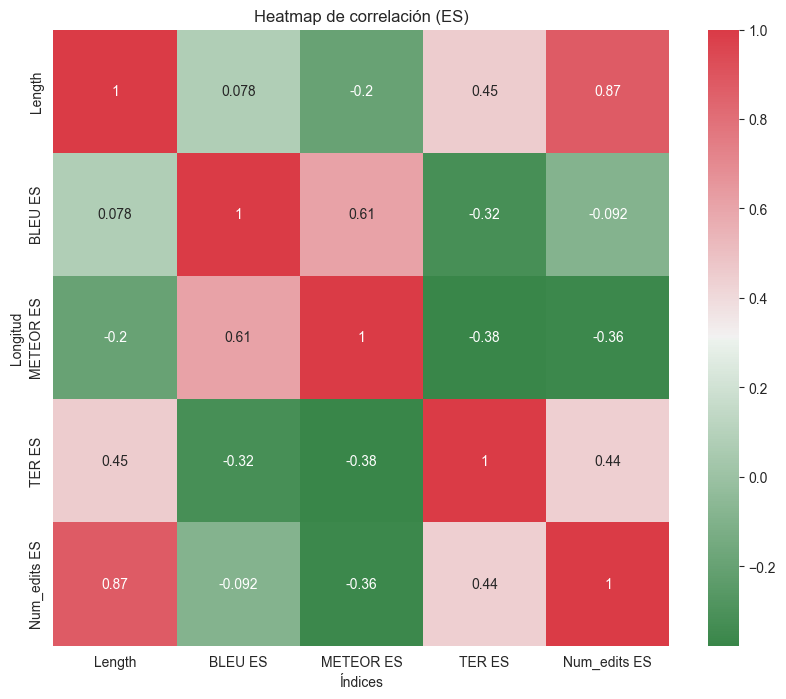

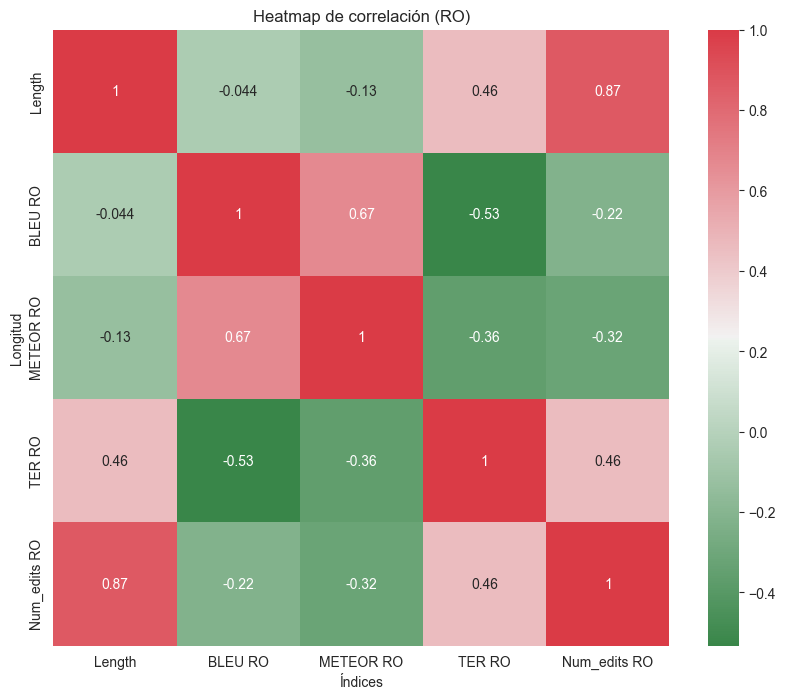

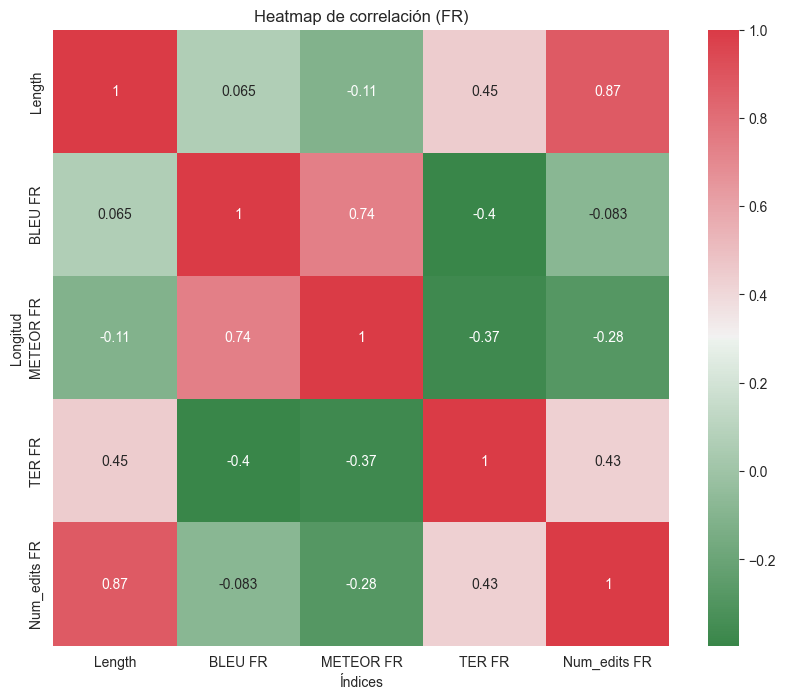

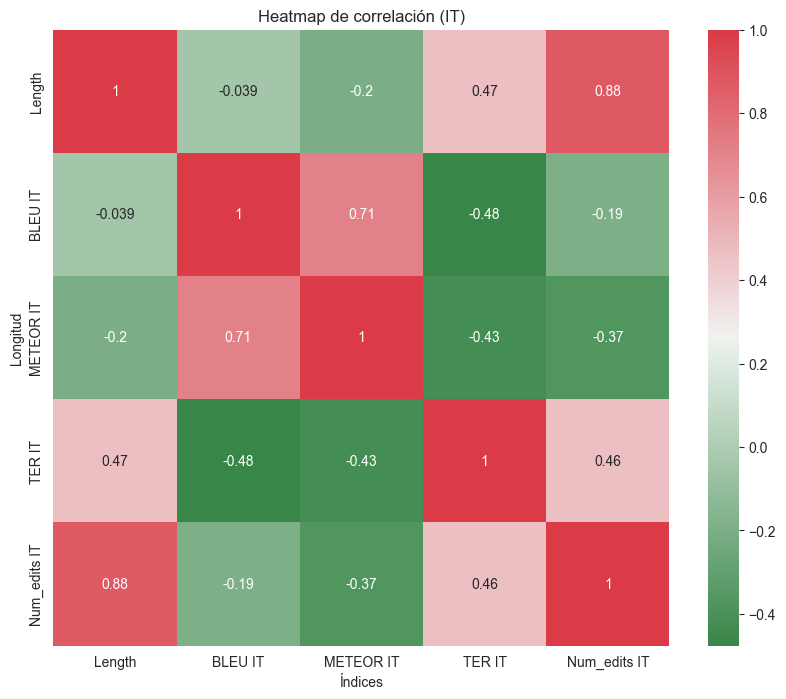

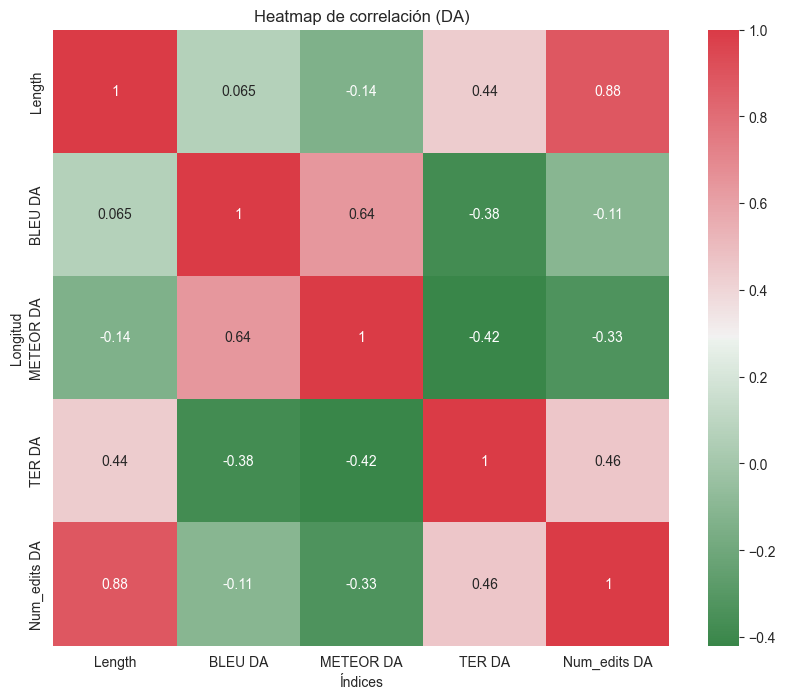

In [205]:
idiomas = ['ES', 'RO', 'FR', 'IT', 'DA']
indices = ['BLEU', 'METEOR', 'TER', 'Num_edits']

for idioma in idiomas:
    # Crear un subconjunto de datos con la longitud y los índices
    subset_data = df[['Length'] + [f'{indice} {idioma}' for indice in indices]]
    
    # Calcular la matriz de correlación
    corr_matrix = subset_data.corr()
    
    # Crear un heatmap utilizando seaborn
    plt.figure(figsize=(10, 8))
    cmap = sns.diverging_palette(133, 10, as_cmap=True)
    sns.heatmap(data=corr_matrix, cmap=cmap, annot=True, square=True)
    plt.title(f'Heatmap de correlación ({idioma})')
    plt.xlabel('Índices')
    plt.ylabel('Longitud')
    plt.show()

Tan solo, como es obvio, se observa relación entre la longitud del fragmento traducido y el número de ediciones. A mayor longitud de texto, también hay más posibilidades de editar ante incorreciones.  Por tanto, se pasa a observar los datos con gráficos de dispersión.

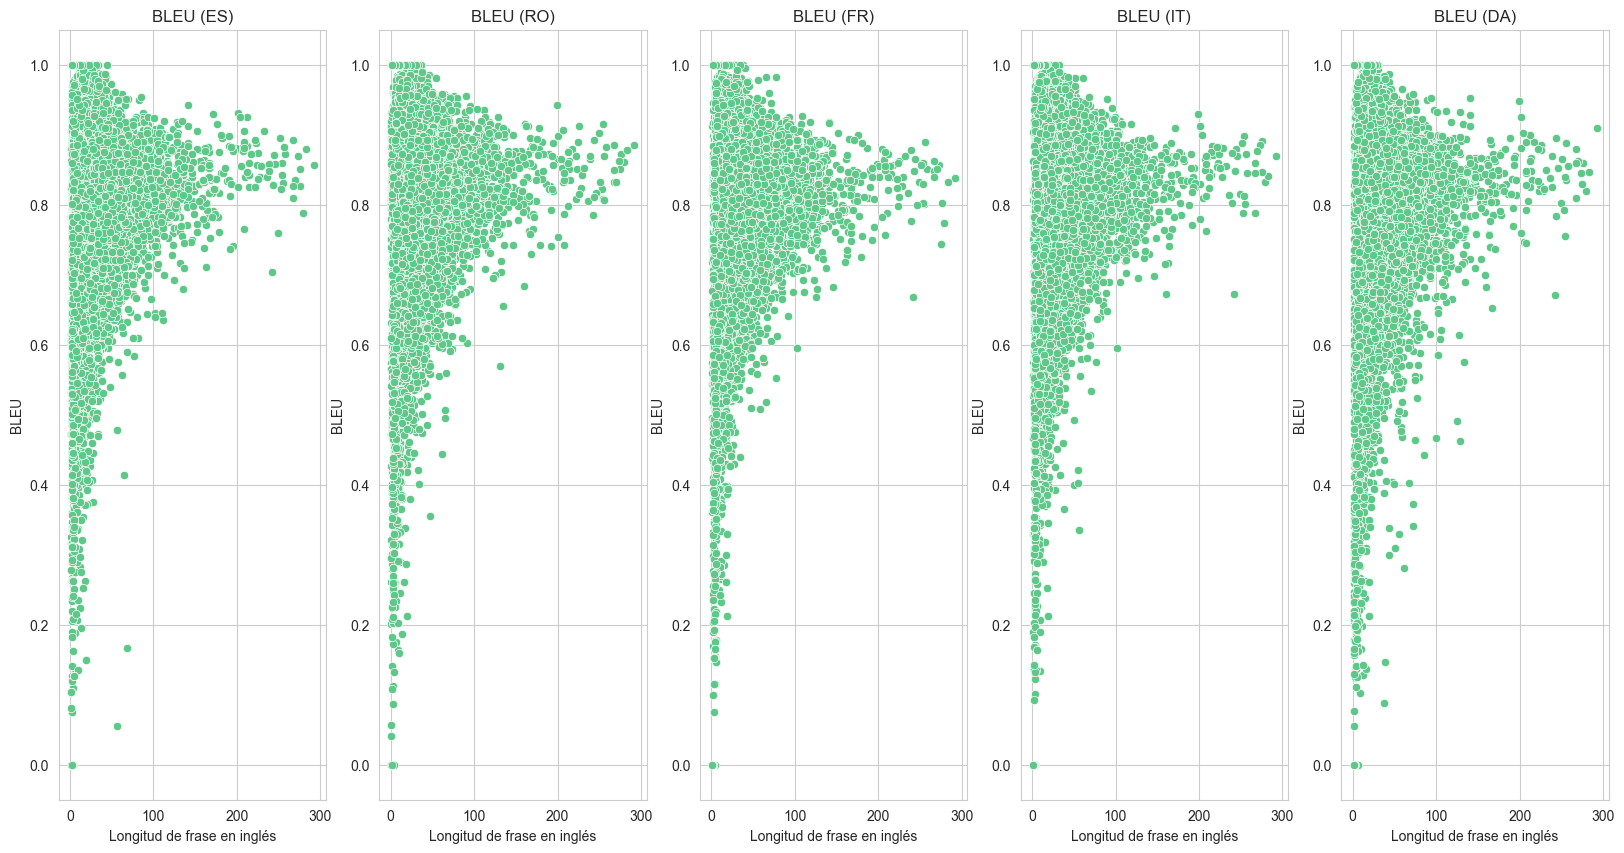

In [207]:
idiomas = ['ES', 'RO', 'FR', 'IT', 'DA']

fig, axs = plt.subplots(1, len(idiomas), figsize=(20, 10))

for j, idioma in enumerate(idiomas):
    ax = axs[j]

    x = df['Length']
    y = df[f'BLEU {idioma}']
        
    sns.scatterplot(data=df, x=x, y=y, ax=ax, color="#5EC888")
    ax.set_title(f'BLEU ({idioma})')
    ax.set_xlabel('Longitud de frase en inglés')
    ax.set_ylabel("BLEU")
    ax.grid(True)

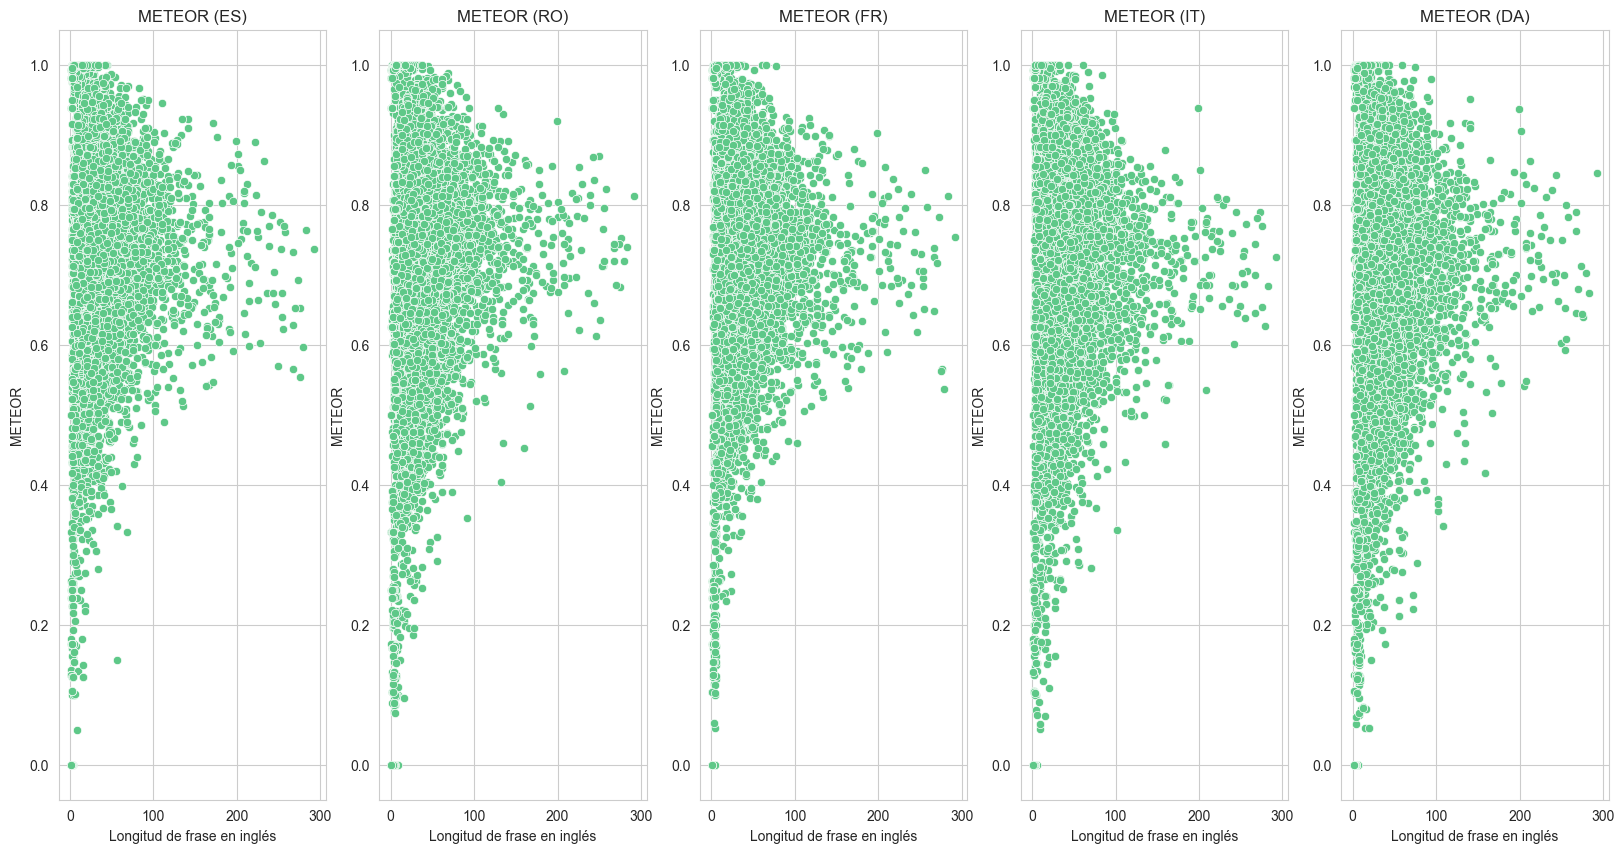

In [209]:
idiomas = ['ES', 'RO', 'FR', 'IT', 'DA']

fig, axs = plt.subplots(1, len(idiomas), figsize=(20, 10))

for j, idioma in enumerate(idiomas):
    ax = axs[j]
        
    x = df['Length']
    y = df[f'METEOR {idioma}']
        
    sns.scatterplot(data=df, x=x, y=y, ax=ax, color="#5EC888")
    ax.set_title(f'METEOR ({idioma})')
    ax.set_xlabel('Longitud de frase en inglés')
    ax.set_ylabel("METEOR")
    ax.grid(True)

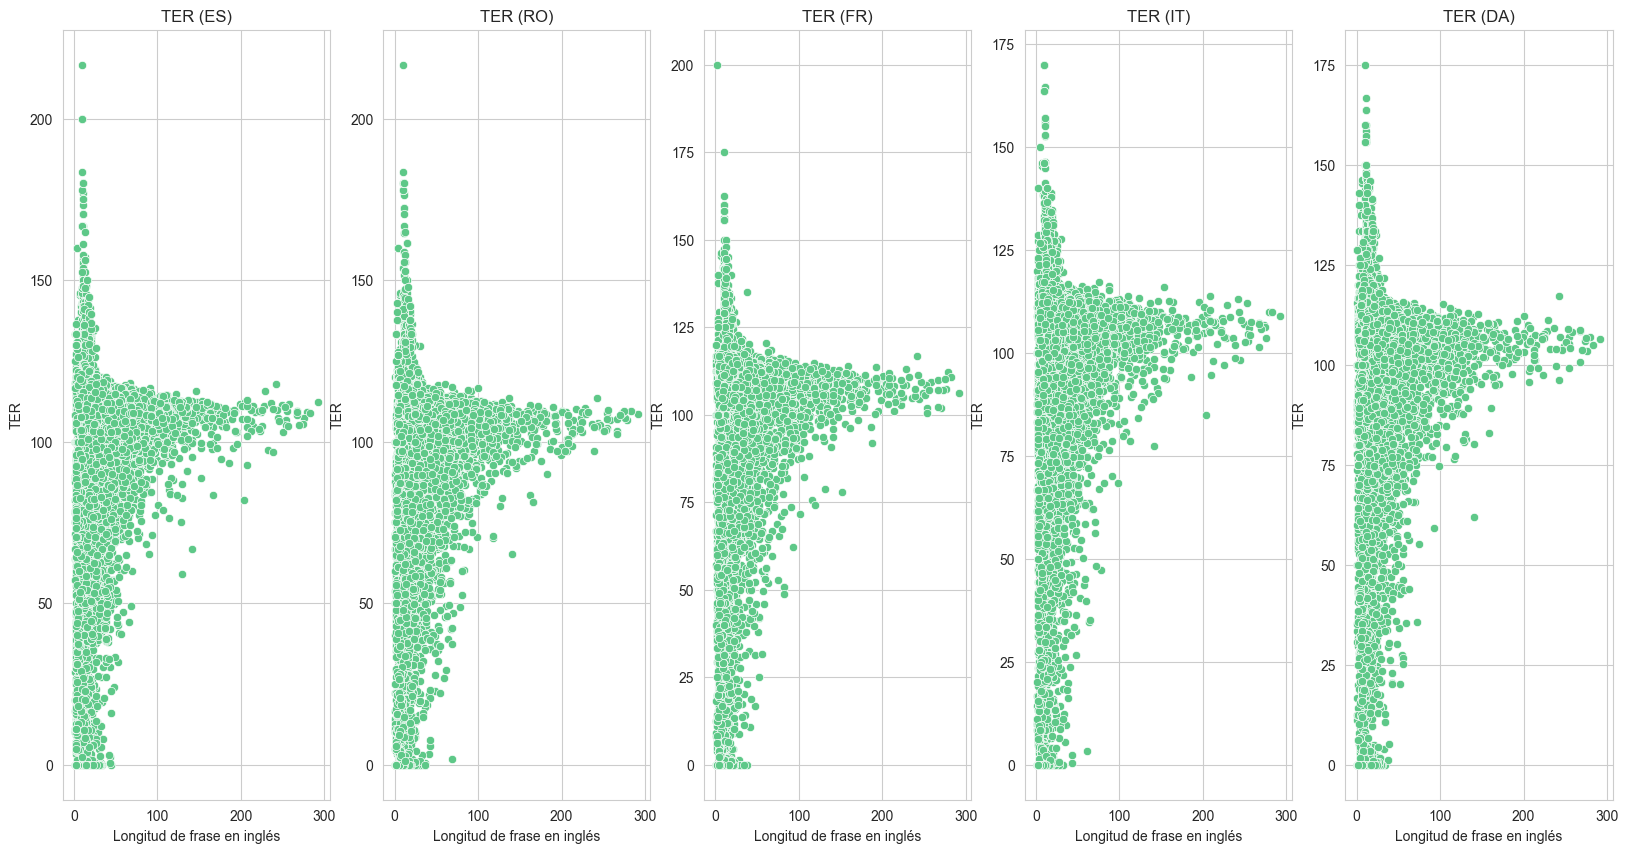

In [210]:
idiomas = ['ES', 'RO', 'FR', 'IT', 'DA']

fig, axs = plt.subplots(1, len(idiomas), figsize=(20, 10))

for j, idioma in enumerate(idiomas):
    ax = axs[j]
        
    x = df['Length']
    y = df[f'TER {idioma}']
        

    sns.scatterplot(data=df, x=x, y=y, ax=ax, color="#5EC888")
    ax.set_title(f'TER ({idioma})')
    ax.set_xlabel('Longitud de frase en inglés')
    ax.set_ylabel("TER")
    ax.grid(True)

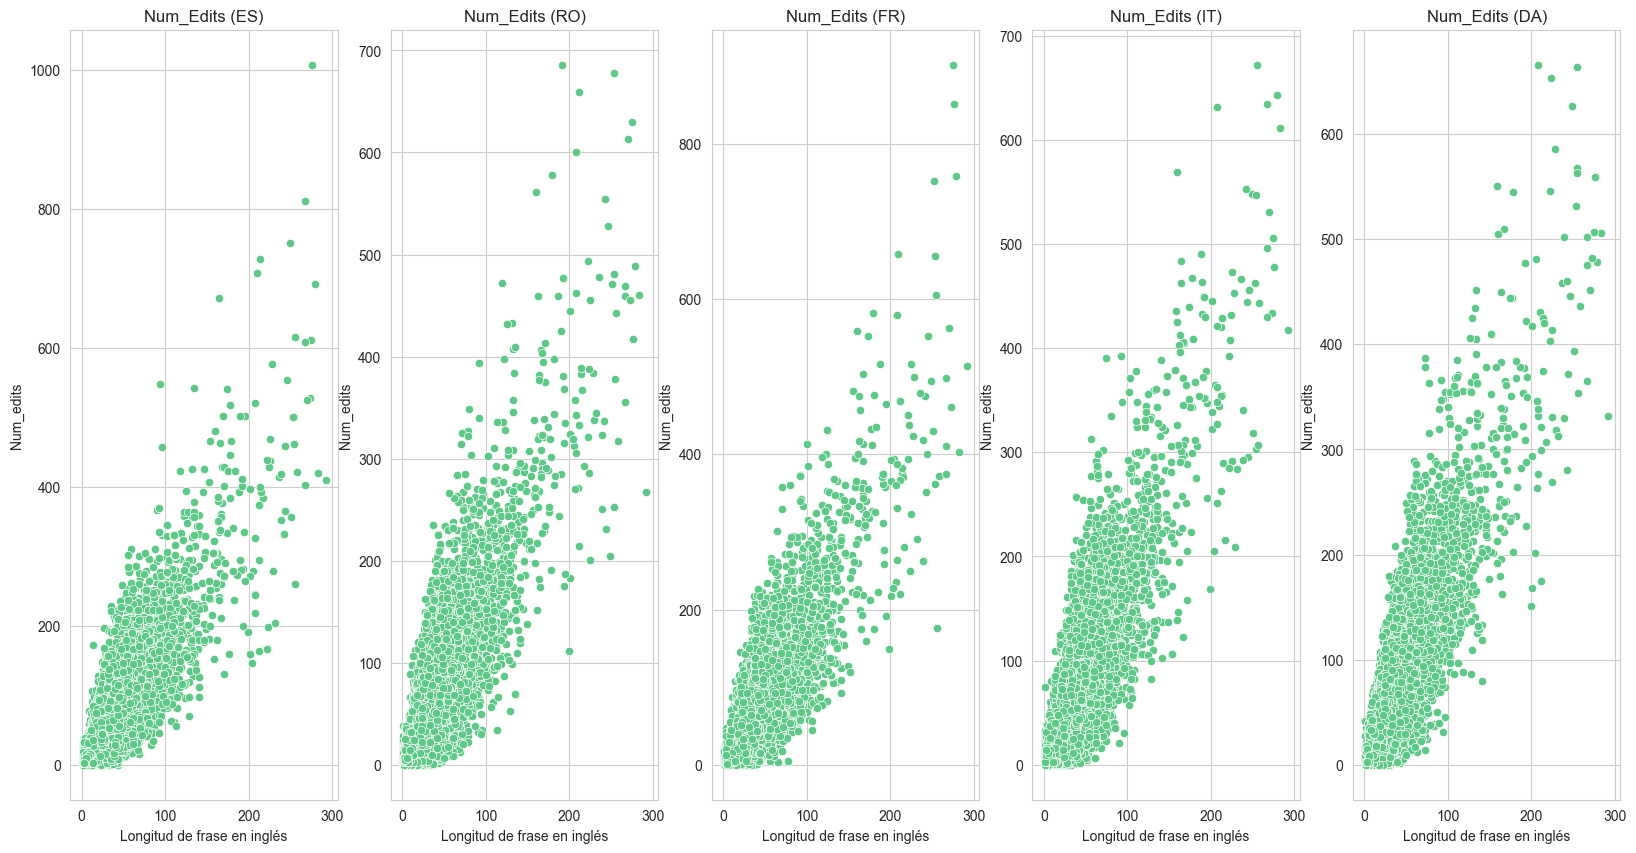

In [211]:
idiomas = ['ES', 'RO', 'FR', 'IT', 'DA']

fig, axs = plt.subplots(1, len(idiomas), figsize=(20, 10))

for j, idioma in enumerate(idiomas):
    ax = axs[j]

    x = df['Length']
    y = df[f'Num_edits {idioma}']

    sns.scatterplot(data=df, x=x, y=y, ax=ax, color="#5EC888")
    ax.set_title(f'Num_Edits ({idioma})')
    ax.set_xlabel('Longitud de frase en inglés')
    ax.set_ylabel("Num_edits")
    ax.grid(True)

Calculamos la simetría de los índices por cada idioma y simetría positiva en el caso de número de ediciones, que como era de esperar, aumenta con la longitud del texto.

In [110]:
idiomas = ['ES', 'RO', 'FR', 'IT', 'DA']
indices = ['BLEU', 'METEOR', 'TER', 'Num_edits']
for idioma in idiomas:
    for indice in indices:
        x = df['Length']
        y = df[f'{indice} {idioma}']
        coef_simetria = skew(y)
        print(f'Coeficiente de simetría para {indice} {idioma}: {coef_simetria:.2f}')

Coeficiente de simetría para BLEU ES: -1.46
Coeficiente de simetría para METEOR ES: -1.41
Coeficiente de simetría para TER ES: -0.56
Coeficiente de simetría para Num_edits ES: 3.18
Coeficiente de simetría para BLEU RO: -1.28
Coeficiente de simetría para METEOR RO: -1.33
Coeficiente de simetría para TER RO: -0.56
Coeficiente de simetría para Num_edits RO: 2.92
Coeficiente de simetría para BLEU FR: -1.94
Coeficiente de simetría para METEOR FR: -1.23
Coeficiente de simetría para TER FR: -0.71
Coeficiente de simetría para Num_edits FR: 3.29
Coeficiente de simetría para BLEU IT: -1.70
Coeficiente de simetría para METEOR IT: -1.13
Coeficiente de simetría para TER IT: -0.60
Coeficiente de simetría para Num_edits IT: 2.86
Coeficiente de simetría para BLEU DA: -1.49
Coeficiente de simetría para METEOR DA: -1.20
Coeficiente de simetría para TER DA: -0.69
Coeficiente de simetría para Num_edits DA: 2.58


En este caso, sí podemos observar una simetría negativa, es decir, a mayor longitud de frase menor es la calidad de la traducción. En principio, animaría a rechazar rotundamente la hipótesis nula. Pero si se vuelve a echar un vistazo a la gráfica, se observa que en frases largas, no hay valores cercanos a 1 en los índices BLEU y Meteor, ni a 0 en TER.

In [111]:
idiomas = ['ES', 'RO', 'FR', 'IT', 'DA']

for idioma in idiomas:
    cortas_bleu = df[df["Length"] < 150]
    media_cortas_bleu = round(cortas_bleu[f'BLEU {idioma}'].mean(), 4)
    std_cortas_bleu = round(cortas_bleu[f'BLEU {idioma}'].std(), 4)
    min_cortas_bleu = round(cortas_bleu[f'BLEU {idioma}'].min(), 4)
    max_cortas_bleu = round(cortas_bleu[f'BLEU {idioma}'].max(), 4)
    print(f"Media fragmentos cortos {idioma}: {media_cortas_bleu}")
    print(f"Desviación fragmentos cortos {idioma}: {std_cortas_bleu}")
    print(f"Mínimo fragmentos cortos {idioma}: {min_cortas_bleu}")
    print(f"Máximo fragmentos cortos {idioma}: {max_cortas_bleu}")

    largas_bleu = df[df["Length"] >= 150]
    media_largas_bleu = round(largas_bleu[f'BLEU {idioma}'].mean(), 4)
    std_largas_bleu = round(largas_bleu[f'BLEU {idioma}'].std(), 4)
    min_largas_bleu = round(largas_bleu[f'BLEU {idioma}'].min(), 4)
    max_largas_bleu = round(largas_bleu[f'BLEU {idioma}'].max(), 4)
    print(f"Media fragmentos largos {idioma}: {media_largas_bleu}")
    print(f"Desviación fragmentos largos {idioma}: {std_largas_bleu}")
    print(f"Mínimo fragmentos largos {idioma}: {min_largas_bleu}")
    print(f"Máximo fragmentos largos {idioma}: {max_largas_bleu}")

Media fragmentos cortos ES: 0.7873
Desviación fragmentos cortos ES: 0.1488
Mínimo fragmentos cortos ES: 0.0
Máximo fragmentos cortos ES: 1.0
Media fragmentos largos ES: 0.8417
Desviación fragmentos largos ES: 0.0455
Mínimo fragmentos largos ES: 0.704
Máximo fragmentos largos ES: 0.931
Media fragmentos cortos RO: 0.8146
Desviación fragmentos cortos RO: 0.1543
Mínimo fragmentos cortos RO: 0.0
Máximo fragmentos cortos RO: 1.0
Media fragmentos largos RO: 0.8409
Desviación fragmentos largos RO: 0.0446
Mínimo fragmentos largos RO: 0.684
Máximo fragmentos largos RO: 0.943
Media fragmentos cortos FR: 0.7813
Desviación fragmentos cortos FR: 0.196
Mínimo fragmentos cortos FR: 0.0
Máximo fragmentos cortos FR: 1.0
Media fragmentos largos FR: 0.8223
Desviación fragmentos largos FR: 0.0422
Mínimo fragmentos largos FR: 0.668
Máximo fragmentos largos FR: 0.902
Media fragmentos cortos IT: 0.8095
Desviación fragmentos cortos IT: 0.1653
Mínimo fragmentos cortos IT: 0.0
Máximo fragmentos cortos IT: 1.0
Me

In [112]:
idiomas = ['ES', 'RO', 'FR', 'IT', 'DA']
for idioma in idiomas:
    cortas_meteor = df[df["Length"] < 150]
    media_cortas_meteor = round(cortas_meteor[f'METEOR {idioma}'].mean(), 4)
    std_cortas_meteor = round(cortas_meteor[f'METEOR {idioma}'].std(), 4)
    min_cortas_meteor = round(cortas_meteor[f'METEOR {idioma}'].min(), 4)
    max_cortas_meteor = round(cortas_meteor[f'METEOR {idioma}'].max(), 4)
    print(f"Media fragmentos cortos {idioma}: {media_cortas_meteor}")
    print(f"Desviación fragmentos cortos: {idioma}: {std_cortas_meteor}")
    print(f"Mínimo fragmentos cortos {idioma}: {min_cortas_meteor}")
    print(f"Máximo fragmentos cortos: {idioma}: {max_cortas_meteor}")


# Cálculo de medidas descriptivas para frases largas
    largas_meteor = df[df["Length"] >= 150]
    media_largas_meteor = round(largas_meteor[f'METEOR {idioma}'].mean(), 4)
    std_largas_meteor = round(largas_meteor[f'METEOR {idioma}'].std(), 4)
    min_largas_meteor = round(largas_meteor[f'METEOR {idioma}'].min(), 4)
    max_largas_meteor = round(largas_meteor[f'METEOR {idioma}'].max(), 4)
    print(f"Media fragmenos largos {idioma}: {media_largas_meteor}")
    print(f"Desviación fragmentos largos {idioma}: {std_largas_meteor}")
    print(f"Mínimo fragmenos largos {idioma}: {min_largas_meteor}")
    print(f"Máximo fragmentos largos {idioma}: {max_largas_meteor}")

Media fragmentos cortos ES: 0.8074
Desviación fragmentos cortos: ES: 0.1811
Mínimo fragmentos cortos ES: 0.0
Máximo fragmentos cortos: ES: 1.0
Media fragmenos largos ES: 0.7125
Desviación fragmentos largos ES: 0.0858
Mínimo fragmenos largos ES: 0.541
Máximo fragmentos largos ES: 0.917
Media fragmentos cortos RO: 0.7841
Desviación fragmentos cortos: RO: 0.1964
Mínimo fragmentos cortos RO: 0.0
Máximo fragmentos cortos: RO: 1.0
Media fragmenos largos RO: 0.7358
Desviación fragmentos largos RO: 0.0762
Mínimo fragmenos largos RO: 0.452
Máximo fragmentos largos RO: 0.92
Media fragmentos cortos FR: 0.781
Desviación fragmentos cortos: FR: 0.1881
Mínimo fragmentos cortos FR: 0.0
Máximo fragmentos cortos: FR: 1.0
Media fragmenos largos FR: 0.7159
Desviación fragmentos largos FR: 0.0792
Mínimo fragmenos largos FR: 0.537
Máximo fragmentos largos FR: 0.903
Media fragmentos cortos IT: 0.7836
Desviación fragmentos cortos: IT: 0.1892
Mínimo fragmentos cortos IT: 0.0
Máximo fragmentos cortos: IT: 1.0
M

In [113]:
idiomas = ['ES', 'RO', 'FR', 'IT', 'DA']
for idioma in idiomas:
    cortas_ter = df[df["Length"] < 150]
    media_cortas_ter = round(cortas_ter[f'TER {idioma}'].mean(), 4)
    std_cortas_ter = round(cortas_ter[f'TER {idioma}'].std(), 4)
    min_cortas_ter = round(cortas_ter[f'TER {idioma}'].min(), 4)
    max_cortas_ter = round(cortas_ter[f'TER {idioma}'].max(), 4)
    print(f"Media fragmentos cortos {idioma}: {media_cortas_ter}")
    print(f"Desviación fragmentos cortos: {idioma}: {std_cortas_ter}")
    print(f"Mínimo fragmentos cortos {idioma}: {min_cortas_ter}")
    print(f"Máximo fragmentos cortos: {idioma}: {max_cortas_ter}")


# Cálculo de medidas descriptivas para frases largas
    largas_ter = df[df["Length"] >= 150]
    media_largas_ter = round(largas_ter[f'TER {idioma}'].mean(), 4)
    std_largas_ter = round(largas_ter[f'TER {idioma}'].std(), 4)
    min_largas_ter = round(largas_ter[f'TER {idioma}'].min(), 4)
    max_largas_ter = round(largas_ter[f'TER {idioma}'].max(), 4)
    print(f"Media fragmenos largos {idioma}: {media_largas_ter}")
    print(f"Desviación fragmentos largos {idioma}: {std_largas_ter}")
    print(f"Mínimo fragmenos largos {idioma}: {min_largas_ter}")
    print(f"Máximo fragmentos largos {idioma}: {max_largas_ter}")

Media fragmentos cortos ES: 71.0011
Desviación fragmentos cortos: ES: 48.7749
Mínimo fragmentos cortos ES: 0.0
Máximo fragmentos cortos: ES: 216.667
Media fragmenos largos ES: 106.5939
Desviación fragmentos largos ES: 5.653
Mínimo fragmenos largos ES: 82.064
Máximo fragmentos largos ES: 117.934
Media fragmentos cortos RO: 68.6211
Desviación fragmentos cortos: RO: 46.4855
Mínimo fragmentos cortos RO: 0.0
Máximo fragmentos cortos: RO: 216.667
Media fragmenos largos RO: 104.4032
Desviación fragmentos largos RO: 5.5952
Mínimo fragmenos largos RO: 81.347
Máximo fragmentos largos RO: 113.509
Media fragmentos cortos FR: 73.2052
Desviación fragmentos cortos: FR: 46.1833
Mínimo fragmentos cortos FR: 0.0
Máximo fragmentos cortos: FR: 200.0
Media fragmenos largos FR: 106.8802
Desviación fragmentos largos FR: 4.6665
Mínimo fragmenos largos FR: 78.049
Máximo fragmentos largos FR: 116.883
Media fragmentos cortos IT: 69.9484
Desviación fragmentos cortos: IT: 46.5572
Mínimo fragmentos cortos IT: 0.0
M

In [169]:
idiomas = ['RO', 'FR', 'IT', 'ES', 'DA']
for idioma in idiomas:
    cortas_num_edits = df[df["Length"] < 150]
    media_cortas_num_edits = round(cortas_num_edits[f'Num_edits {idioma}'].mean(), 4)
    std_cortas_num_edits = round(cortas_num_edits[f'Num_edits {idioma}'].std(), 4)
    min_cortas_num_edits = round(cortas_num_edits[f'Num_edits {idioma}'].min(), 4)
    max_cortas_num_edits = round(cortas_num_edits[f'Num_edits {idioma}'].max(), 4)
    print(f"Media fragmentos cortos {idioma}: {media_cortas_num_edits}")
    print(f"Desviación fragmentos cortos: {idioma}: {std_cortas_num_edits}")
    print(f"Mínimo fragmentos cortos {idioma}: {min_cortas_num_edits}")
    print(f"Máximo fragmentos cortos: {idioma}: {max_cortas_num_edits}")


# Cálculo de medidas descriptivas para frases largas
    largas_num_edits = df[df["Length"] >= 150]
    media_largas_num_edits = round(largas_num_edits[f'Num_edits {idioma}'].mean(), 4)
    std_largas_num_edits = round(largas_num_edits[f'TER {idioma}'].std(), 4)
    min_largas_num_edits = round(largas_num_edits[f'Num_edits {idioma}'].min(), 4)
    max_largas_num_edits = round(largas_num_edits[f'TER {idioma}'].max(), 4)
    print(f"Mínimo fragmenos largos {idioma}: {min_largas_num_edits}")
    print(f"Máximo fragmentos largos {idioma}: {max_largas_num_edits}")

Media fragmentos cortos RO: 38.7649
Desviación fragmentos cortos: RO: 52.6644
Mínimo fragmentos cortos RO: 0.0
Máximo fragmentos cortos: RO: 472.0
Mínimo fragmenos largos RO: 111.0
Máximo fragmentos largos RO: 113.509
Media fragmentos cortos FR: 40.0615
Desviación fragmentos cortos: FR: 53.6737
Mínimo fragmentos cortos FR: 0.0
Máximo fragmentos cortos: FR: 431.0
Mínimo fragmenos largos FR: 120.0
Máximo fragmentos largos FR: 116.883
Media fragmentos cortos IT: 40.065
Desviación fragmentos cortos: IT: 54.0403
Mínimo fragmentos cortos IT: 0.0
Máximo fragmentos cortos: IT: 392.0
Mínimo fragmenos largos IT: 106.0
Máximo fragmentos largos IT: 116.116
Media fragmentos cortos ES: 42.0589
Desviación fragmentos cortos: ES: 56.8951
Mínimo fragmentos cortos ES: 0.0
Máximo fragmentos cortos: ES: 548.0
Mínimo fragmenos largos ES: 130.0
Máximo fragmentos largos ES: 117.934
Media fragmentos cortos DA: 45.3006
Desviación fragmentos cortos: DA: 58.8889
Mínimo fragmentos cortos DA: 0.0
Máximo fragmentos 

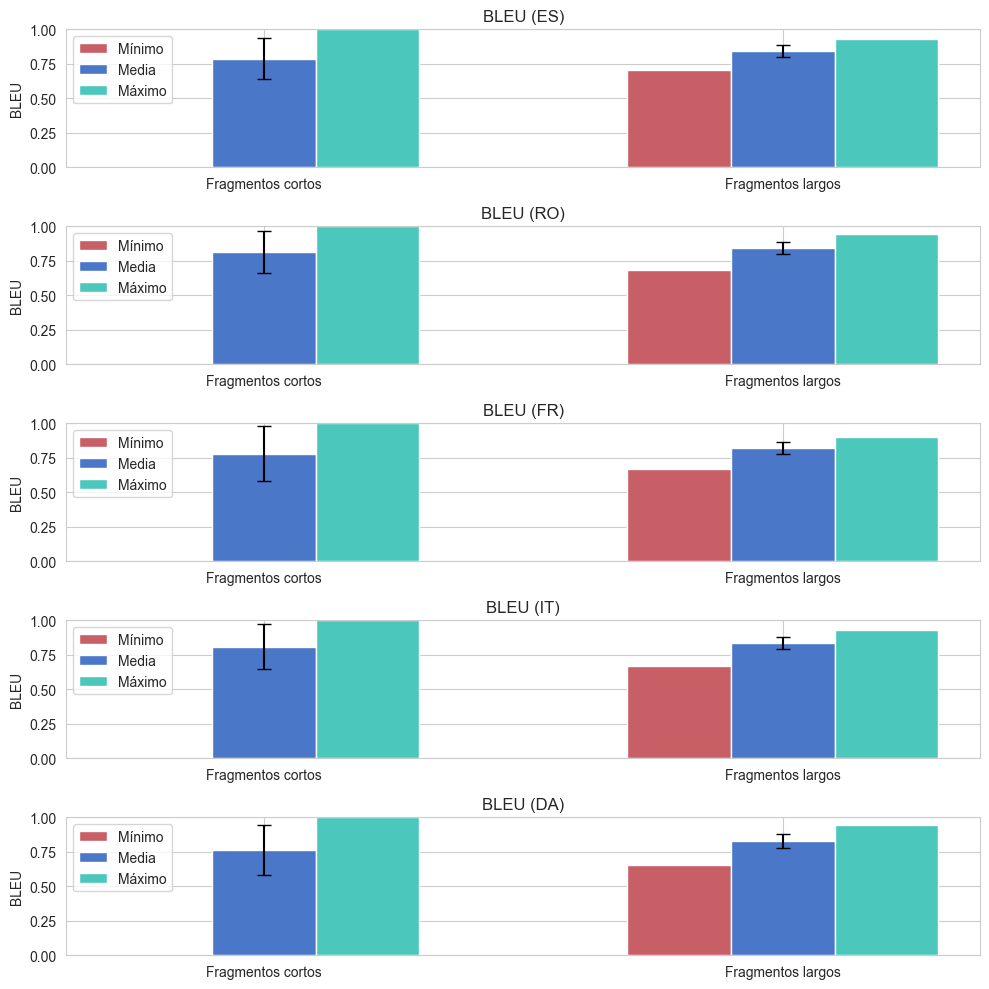

In [217]:
idiomas = ['ES', 'RO', 'FR', 'IT', 'DA']

fig, axs = plt.subplots(len(idiomas), figsize=(10, 10))

for i, idioma in enumerate(idiomas):
    # Obtener datos para fragmentos cortos y largos de BLEU
    cortas_bleu = df[df["Length"] < 150][f'BLEU {idioma}']
    largas_bleu = df[df["Length"] >= 150][f'BLEU {idioma}']

    # Calcular la media, mínimo y máximo de los datos
    media_cortas_bleu = cortas_bleu.mean()
    media_largas_bleu = largas_bleu.mean()
    min_cortas_bleu = cortas_bleu.min()
    min_largas_bleu = largas_bleu.min()
    max_cortas_bleu = cortas_bleu.max()
    max_largas_bleu = largas_bleu.max()
    std_cortas_bleu = cortas_bleu.std()
    std_largas_bleu = largas_bleu.std()

    # Configuración de las barras
    bar_width = 0.2
    index = np.arange(2)

    # Dibujar las barras de mínimo, media y máximo para fragmentos cortos
    axs[i].bar(index[0], min_cortas_bleu, width=bar_width, color='#C85E66', label='Mínimo')
    axs[i].bar(index[0] + bar_width, media_cortas_bleu, width=bar_width, color='#4B77C8', label='Media')
    axs[i].bar(index[0] + 2 * bar_width, max_cortas_bleu, width=bar_width, color='#4BC8BB', label='Máximo')
    axs[i].errorbar(index[0] + bar_width, media_cortas_bleu, yerr=std_cortas_bleu, color='black', capsize=5)

    # Dibujar las barras de mínimo, media y máximo para fragmentos largos
    axs[i].bar(index[1], min_largas_bleu, width=bar_width, color='#C85E66')
    axs[i].bar(index[1] + bar_width, media_largas_bleu, width=bar_width, color='#4B77C8')
    axs[i].bar(index[1] + 2 * bar_width, max_largas_bleu, width=bar_width, color='#4BC8BB')
    axs[i].errorbar(index[1] + bar_width, media_largas_bleu, yerr=std_largas_bleu, color='black', capsize=5)

    # Etiquetas y títulos
    axs[i].set_xticks(index + bar_width)
    axs[i].set_ylim(0,1)
    axs[i].set_xticklabels(['Fragmentos cortos', 'Fragmentos largos'])
    axs[i].set_title(f'BLEU ({idioma})')
    axs[i].set_ylabel('BLEU')
    axs[i].legend()

# Ajustar el espacio entre subplots
plt.tight_layout()



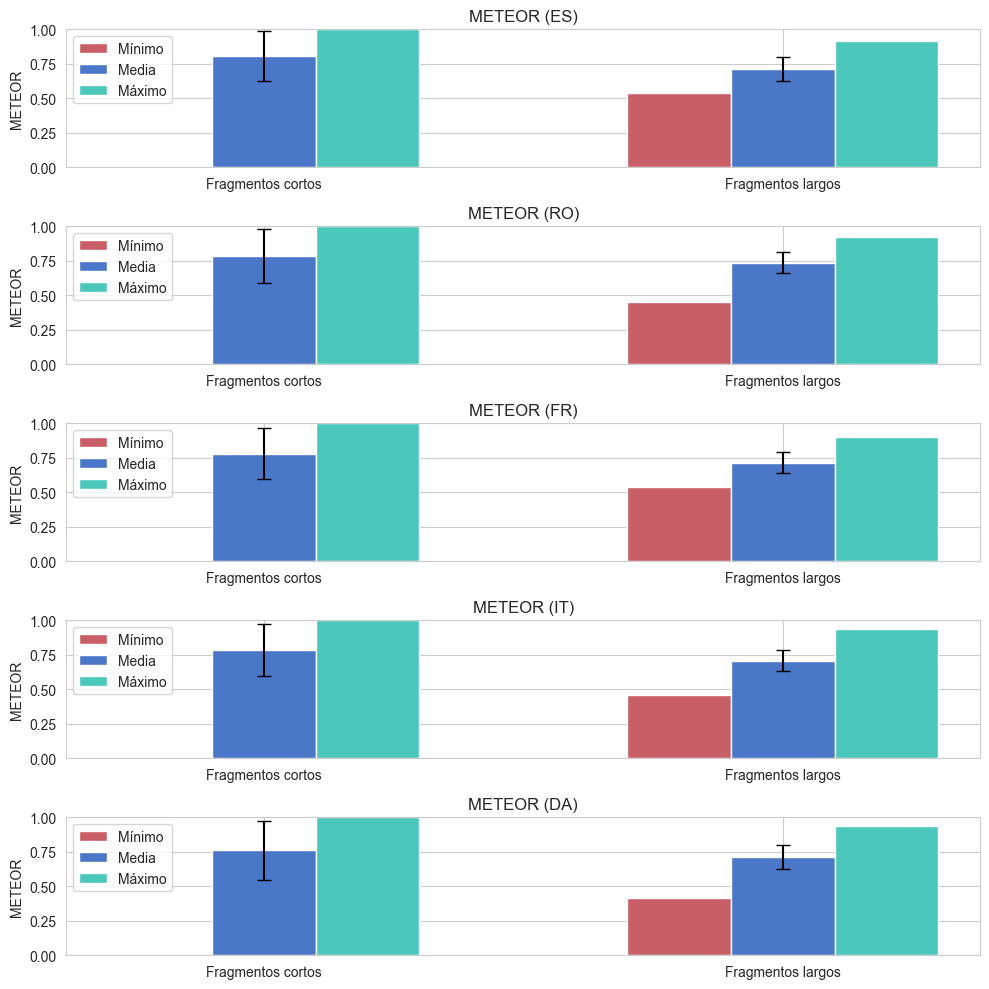

In [248]:

idiomas = ['ES', 'RO', 'FR', 'IT', 'DA']

# Configuración del gráfico
fig, axs = plt.subplots(len(idiomas), figsize=(10, 10))

# Iterar sobre cada idioma
for i, idioma in enumerate(idiomas):
    # Obtener datos para fragmentos cortos y largos de METEOR
    cortas_meteor = df[df["Length"] < 150][f'METEOR {idioma}']
    largas_meteor = df[df["Length"] >= 150][f'METEOR {idioma}']

    # Calcular la media, mínimo y máximo de los datos
    media_cortas_meteor = cortas_meteor.mean()
    media_largas_meteor = largas_meteor.mean()
    min_cortas_meteor = cortas_meteor.min()
    min_largas_meteor = largas_meteor.min()
    max_cortas_meteor = cortas_meteor.max()
    max_largas_meteor = largas_meteor.max()
    std_cortas_meteor = cortas_meteor.std()
    std_largas_meteor = largas_meteor.std()

    # Configuración de las barras
    bar_width = 0.2
    index = np.arange(2)

    # Dibujar las barras de mínimo, media y máximo para fragmentos cortos
    axs[i].bar(index[0], min_cortas_meteor, width=bar_width, color='#C85E66', label='Mínimo')
    axs[i].bar(index[0] + bar_width, media_cortas_meteor, width=bar_width, color='#4B77C8', label='Media')
    axs[i].bar(index[0] + 2 * bar_width, max_cortas_meteor, width=bar_width, color='#4BC8BB', label='Máximo')
    axs[i].errorbar(index[0] + bar_width, media_cortas_meteor, yerr=std_cortas_meteor, color='black', capsize=5)

    # Dibujar las barras de mínimo, media y máximo para fragmentos largos
    axs[i].bar(index[1], min_largas_meteor, width=bar_width, color='#C85E66')
    axs[i].bar(index[1] + bar_width, media_largas_meteor, width=bar_width, color='#4B77C8')
    axs[i].bar(index[1] + 2 * bar_width, max_largas_meteor, width=bar_width, color='#4BC8BB')
    axs[i].errorbar(index[1] + bar_width, media_largas_meteor, yerr=std_largas_meteor, color='black', capsize=5)

    # Etiquetas y títulos
    axs[i].set_xticks(index + bar_width)
    axs[i].set_ylim(0,1)
    axs[i].set_xticklabels(['Fragmentos cortos', 'Fragmentos largos'])
    axs[i].set_title(f'METEOR ({idioma})')
    axs[i].set_ylabel('METEOR')
    axs[i].legend()

# Ajustar el espacio entre subplots
plt.tight_layout()

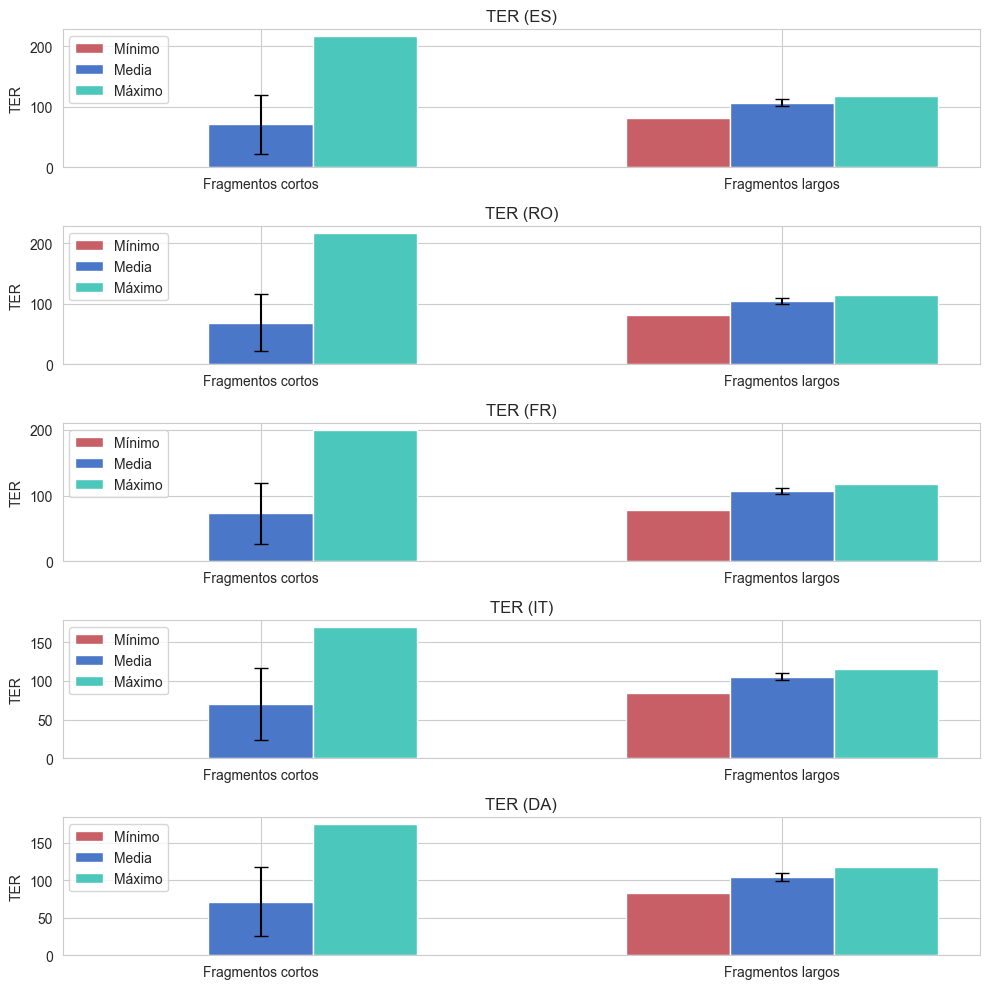

In [249]:
fig, axs = plt.subplots(len(idiomas), figsize=(10, 10))

# Iterar sobre cada idioma
for i, idioma in enumerate(idiomas):
    # Obtener datos para fragmentos cortos y largos de TER
    cortas_ter = df[df["Length"] < 150][f'TER {idioma}']
    largas_ter = df[df["Length"] >= 150][f'TER {idioma}']

    # Calcular la media, mínimo y máximo de los datos
    media_cortas_ter = cortas_ter.mean()
    media_largas_ter = largas_ter.mean()
    min_cortas_ter = cortas_ter.min()
    min_largas_ter = largas_ter.min()
    max_cortas_ter = cortas_ter.max()
    max_largas_ter = largas_ter.max()
    std_cortas_ter = cortas_ter.std()
    std_largas_ter = largas_ter.std()

    # Configuración de las barras
    bar_width = 0.2
    index = np.arange(2)

    # Dibujar las barras de mínimo, media y máximo para fragmentos cortos
    axs[i].bar(index[0], min_cortas_ter, width=bar_width, color='#C85E66', label='Mínimo')
    axs[i].bar(index[0] + bar_width, media_cortas_ter, width=bar_width, color='#4B77C8', label='Media')
    axs[i].bar(index[0] + 2 * bar_width, max_cortas_ter, width=bar_width, color='#4BC8BB', label='Máximo')
    axs[i].errorbar(index[0] + bar_width, media_cortas_ter, yerr=std_cortas_ter, color='black', capsize=5)

    # Dibujar las barras de mínimo, media y máximo para fragmentos largos
    axs[i].bar(index[1], min_largas_ter, width=bar_width, color='#C85E66')
    axs[i].bar(index[1] + bar_width, media_largas_ter, width=bar_width, color='#4B77C8')
    axs[i].bar(index[1] + 2 * bar_width, max_largas_ter, width=bar_width, color='#4BC8BB')
    axs[i].errorbar(index[1] + bar_width, media_largas_ter, yerr=std_largas_ter, color='black', capsize=5)

    # Etiquetas y títulos
    axs[i].set_xticks(index + bar_width)
    axs[i].set_xticklabels(['Fragmentos cortos', 'Fragmentos largos'])
    axs[i].set_title(f'TER ({idioma})')
    axs[i].set_ylabel('TER')
    axs[i].legend()

plt.tight_layout()

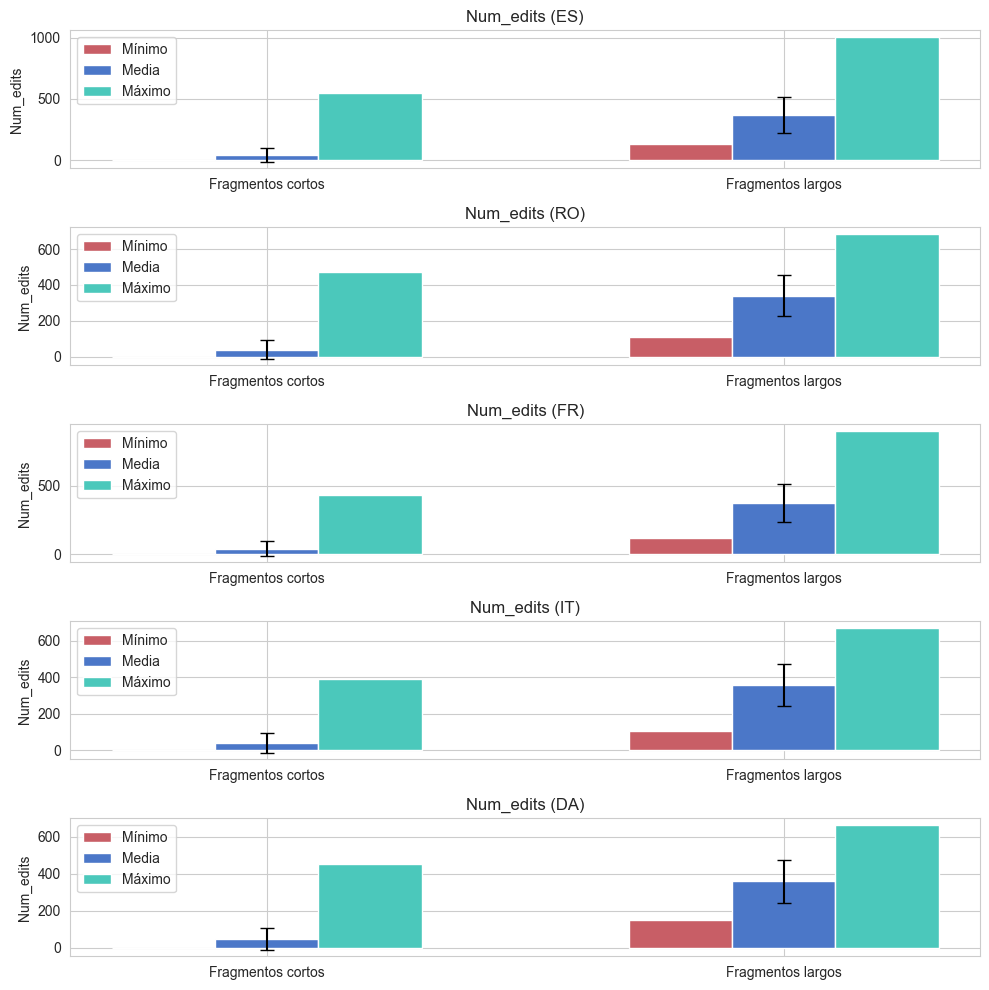

In [220]:
fig, axs = plt.subplots(len(idiomas), figsize=(10, 10))

# Iterar sobre cada idioma
for i, idioma in enumerate(idiomas):
    # Obtener datos para fragmentos cortos y largos de Num_edits
    cortas_num_edits = df[df["Length"] < 150][f'Num_edits {idioma}']
    largas_num_edits = df[df["Length"] >= 150][f'Num_edits {idioma}']

    # Calcular la media, mínimo y máximo de los datos
    media_cortas_num_edits = cortas_num_edits.mean()
    media_largas_num_edits = largas_num_edits.mean()
    min_cortas_num_edits = cortas_num_edits.min()
    min_largas_num_edits = largas_num_edits.min()
    max_cortas_num_edits = cortas_num_edits.max()
    max_largas_num_edits = largas_num_edits.max()
    std_cortas_num_edits = cortas_num_edits.std()
    std_largas_num_edits = largas_num_edits.std()

    # Configuración de las barras
    bar_width = 0.2
    index = np.arange(2)

    # Dibujar las barras de mínimo, media y máximo para fragmentos cortos
    axs[i].bar(index[0], min_cortas_num_edits, width=bar_width, color='#C85E66', label='Mínimo')
    axs[i].bar(index[0] + bar_width, media_cortas_num_edits, width=bar_width, color='#4B77C8', label='Media')
    axs[i].bar(index[0] + 2 * bar_width, max_cortas_num_edits, width=bar_width, color='#4BC8BB', label='Máximo')
    axs[i].errorbar(index[0] + bar_width, media_cortas_num_edits, yerr=std_cortas_num_edits, color='black', capsize=5)

    # Dibujar las barras de mínimo, media y máximo para fragmentos largos
    axs[i].bar(index[1], min_largas_num_edits, width=bar_width, color='#C85E66')
    axs[i].bar(index[1] + bar_width, media_largas_num_edits, width=bar_width, color='#4B77C8')
    axs[i].bar(index[1] + 2 * bar_width, max_largas_num_edits, width=bar_width, color='#4BC8BB')
    axs[i].errorbar(index[1] + bar_width, media_largas_num_edits, yerr=std_largas_num_edits, color='black', capsize=5)

    # Etiquetas y títulos
    axs[i].set_xticks(index + bar_width)
    axs[i].set_xticklabels(['Fragmentos cortos', 'Fragmentos largos'])
    axs[i].set_title(f'Num_edits ({idioma})')
    axs[i].set_ylabel('Num_edits')
    axs[i].legend()

# Ajustar el espacio entre subplots
plt.tight_layout()

Como podemos observar en los gráficos, en cuanto a los índices de calidad y el ratio de ediciones, en frases cortas tenemos valores mínimos que van del 0 al 1, es decir, el traductor automático ha realizado traducciones tanto perfectas como traducciones totalmente erróneas, por tanto, se puede ver también en el número de ediciones que hay ediciones que no necesitan edición. En el caso de las fagmentos largos. observamos que la media no varía mucho respecto a las cortas y según el índice utilizado puede ser ligeramente mayor o menor. La barra de la varianza también nos indica que los valores son significativamente más dispares en los fragmentos cortos. También observamos que en las frases largas no hay ni valores mínimos de 0 ni máximos de 1, en el caso de BLEU y METEOR, ni de 0 y 100 en el caso de TER.

En conclusión, hay que rechazar la hipótesis nula que indice que la calidad de las traducciones de fragmentos más largos son de peor calidad que la de las fragmentos cortos. Observamos que la calidad mejora a medida que el traductor automático recibe más contexto.
Sin embargo, a medida que los fragmentos se van alejando y van siendo más complejos, la calidad se situa en torno al 0,8 calculada con el índice BLEU, en torno al 0,72 calculada con el índice Meteor, en torno a 105 con el índice TER y las ediciones se disparan a unas 350 para los fragmentos largos.
Por tanto, podemos afirmar que en frases cortas la calidad de la traducción automática puede variar ampliamente. Un índice de calidad de 0 indica una traducción muy deficiente, mientras que un índice de calidad de 1 indica una traducción perfecta.
A medida que las fragmentos se hacen más largos, el modelo de traducción automática tiene más contexto para trabajar y puede producir traducciones más consistentes. El hecho de que el índice de calidad se estabilice en un rango específico, como 0.65 a 0.93 en el caso del índice BLEU, puede indicar que el modelo tiende a producir traducciones de bastante calidad en fragmentos largos, pero siempre con un espacio de mejora. Si además nos fijamos en el índice METEOR, que tiene en cuenta más aspectos, como la correctitud gramatical, la ordenación de las palabras y contempla casos de sinonimia, observamos que en este caso el rango se amplia y cuenta con valores de entre 0.45 y 0.93. Por tanto, a pesar de que la traducción automática va mejorando conforme reciba máx contexto, en ningún caso se alcanza ya la "traducción perfecta" que en ocasiones puede llegar a alcanzar en fragmentos cortos.

---

Para la segunda hipótesis, primero ordenaremos los idiomas de menor a mayor en función de su grado de flexión morfológico, explicamente brevemente dicha ordenación.

Rumano: El rumano es considerado uno de los idiomas más flexivos de esta lista. Presenta una amplia variedad de morfemas y flexiones en sustantivos, adjetivos y verbos. En particular, destaca por su sistema de casos gramaticales, con cinco casos diferentes, lo cual permite una expresión precisa de las relaciones sintácticas. Además, tiene una conjugación verbal compleja y rica en tiempos y modos verbales. Estas características lo posicionan como el idioma más flexivo de la lista.

Español: El español es un idioma que también posee una morfología flexiva significativa. Cuenta con conjugaciones verbales extensas que incluyen una amplia variedad de tiempos, modos y personas. Además, muestra flexiones de género y número en sustantivos y adjetivos, aunque en menor medida que el rumano. Estas flexiones permiten una expresión precisa de las relaciones gramaticales y aportan cierto grado de flexibilidad morfológica.

Italiano: El italiano también tiene una morfología flexiva importante, aunque en menor medida que el rumano y el español. Presenta una conjugación verbal extensa con distintos tiempos, modos y personas. Asimismo, muestra variaciones de género y número en sustantivos y adjetivos, y cuenta con ciertos casos gramaticales, aunque en menor medida que el rumano. Estas flexiones aportan cierta flexibilidad morfológica, pero en comparación con los idiomas anteriores, el italiano puede considerarse ligeramente menos flexivo.

Francés: El francés tiene una morfología menos flexiva que el italiano y el español. Aunque cuenta con una conjugación verbal que incluye diversos tiempos y modos verbales, la flexión de género y número en sustantivos y adjetivos es menos marcada que en otros idiomas. El francés ha experimentado una simplificación morfológica a lo largo del tiempo, lo que ha llevado a la pérdida de algunos casos gramaticales y formas flexivas. Aunque aún muestra ciertas flexiones en los artículos y pronombres, así como en algunos adjetivos y sustantivos, su nivel de flexibilidad morfológica es menor en comparación con los idiomas anteriores.

Danés: El danés es el idioma menos flexivo de esta lista. Tiene una morfología relativamente más simplificada en comparación con los idiomas anteriores. Si bien cuenta con flexiones de género y número en sustantivos y adjetivos, su sistema verbal es menos complejo en términos de tiempos y modos verbales en comparación con otros idiomas. Además, ha experimentado una simplificación en la formación de casos gramaticales. Estas características hacen que el danés sea el idioma menos flexivo en esta lista.

Para empezar, dibujaremos gráficos de cajas para observar los datos de cada idioma.

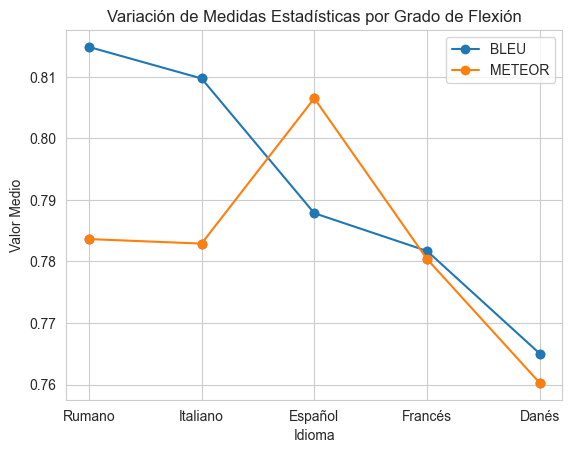

In [245]:
idiomas = ['Rumano', 'Italiano', 'Español', 'Francés', 'Danés']
media_bleu = df[['BLEU RO', 'BLEU IT', 'BLEU ES', 'BLEU FR', 'BLEU DA']].mean()
media_meteor = df[['METEOR RO', 'METEOR IT', 'METEOR ES', 'METEOR FR', 'METEOR DA']].mean()

plt.plot(idiomas, media_bleu, marker='o', label='BLEU')
plt.plot(idiomas, media_meteor, marker='o', label='METEOR')
plt.scatter(idiomas, media_bleu, c="#5C8CE5")
plt.scatter(idiomas, media_meteor, c='#AC2B6F')
plt.title('Variación de Medidas Estadísticas por Grado de Flexión')
plt.xlabel('Idioma')
plt.ylabel('Valor Medio')
plt.legend()

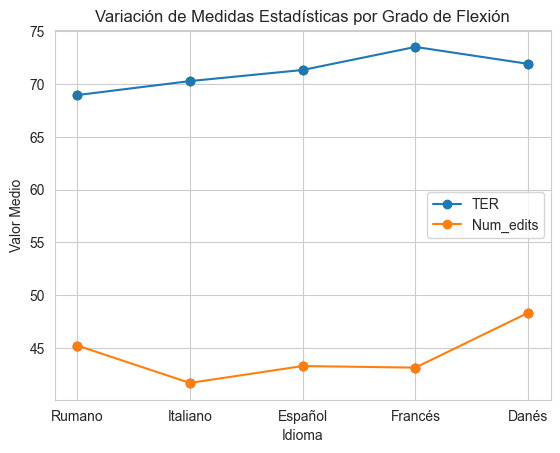

In [183]:
idiomas = ['Rumano', 'Italiano', 'Español', 'Francés', 'Danés']
media_ter = df[['TER RO', 'TER IT', 'TER ES', 'TER FR', 'TER DA']].mean()
media_num_edits = df[['Num_edits ES', 'Num_edits RO', 'Num_edits FR', 'Num_edits IT', 'Num_edits DA']].mean()


plt.plot(idiomas, media_ter, marker='o', label='TER')
plt.plot(idiomas, media_num_edits, marker='o', label='Num_edits')

plt.scatter(idiomas, media_ter)
plt.scatter(idiomas, media_num_edits)

plt.title('Variación de Medidas Estadísticas por Grado de Flexión')
plt.xlabel('Idioma')
plt.ylabel('Valor Medio')
plt.legend()

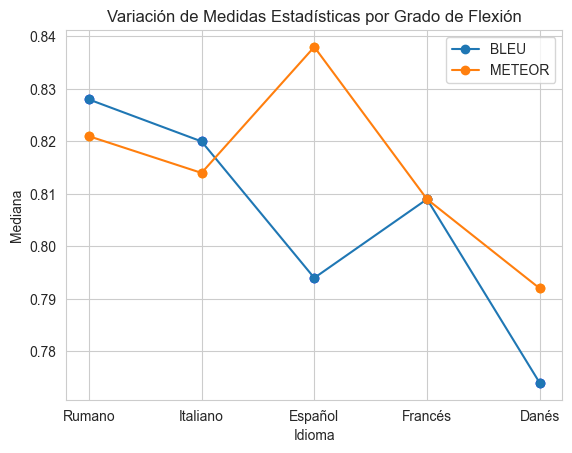

In [192]:
idiomas = ['Rumano', 'Italiano', 'Español', 'Francés', 'Danés']
median_bleu = df[['BLEU RO', 'BLEU IT', 'BLEU ES', 'BLEU FR', 'BLEU DA']].median()
median_meteor = df[['METEOR RO', 'METEOR IT', 'METEOR ES', 'METEOR FR', 'METEOR DA']].median()

plt.plot(idiomas, median_bleu, marker='o', label='BLEU')
plt.plot(idiomas, median_meteor, marker='o', label='METEOR')
plt.scatter(idiomas, median_bleu, color='#2B72AD')
plt.scatter(idiomas, median_meteor, color='#AC2B6F')
plt.title('Variación de Medidas Estadísticas por Grado de Flexión')
plt.xlabel('Idioma')
plt.ylabel('Mediana')
plt.legend()

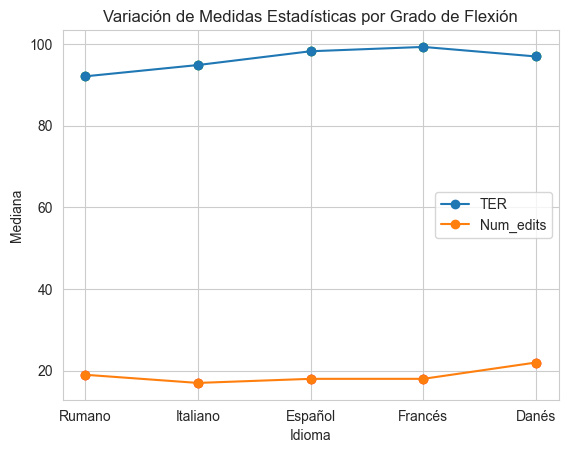

In [193]:
idiomas = ['Rumano', 'Italiano', 'Español', 'Francés', 'Danés']
median_ter = df[['TER RO', 'TER IT', 'TER ES', 'TER FR', 'TER DA']].median()
median_num_edits = df[['Num_edits ES', 'Num_edits RO', 'Num_edits FR', 'Num_edits IT', 'Num_edits DA']].median()


plt.plot(idiomas, median_ter, marker='o', label='TER')
plt.plot(idiomas, median_num_edits, marker='o', label='Num_edits')
plt.scatter(idiomas, median_ter, color='green')
plt.scatter(idiomas, median_num_edits, color='red')
plt.title('Variación de Medidas Estadísticas por Grado de Flexión')
plt.xlabel('Idioma')
plt.ylabel('Mediana')
plt.legend()

Como podemos observar, no hay una relación clara entre la flexión de los idiomas y la calidad de su traducción automática. Según el índice BLEU incluso podemos ver que se produce el efecto contrario. Por tanto, rechazamos la hipótesis
Este año Google ha integrado IA a su traductor y parece que hay idiomas como el rumano, que ha resultado muy beneficiado por esta incorporación y que según el índice BLEU recibe la mejor puntuación pesar de ser el idioma más flexivo.
En cuanto al índice Meteor, que contempla la correción gramatical y la sinonímia de palabras, y que se suele considerar que más próximo a una evaluación humana de la traducción que el BLEU, vemos que el español es el que obtiene mejores resultados con diferencia. Un factor que podría influir en este resultado es el gran contenido de texto que hay en Internet. Según Internet World Stats, en 2020, los usuarios del español en Internet es de 7.9%, el del francés de 3,3 y el resto no aparecen entre los diez idiomas con mayor número de usuarios, por tanto su uso es de menos de un 2%.